# Mouse Mammary RNA-seq: edgeR vs edgePython Side-by-Side Comparison

This notebook runs the **edgePython** differential expression pipeline on the GSE60450 mouse mammary dataset and compares results side-by-side with pre-computed **edgeR** outputs. The data are from [Fu et al. (2015)](https://www.nature.com/articles/ncb3117) and this analysis follows the [Galaxy RNA-seq counts to genes tutorial](https://training.galaxyproject.org/training-material/topics/transcriptomics/tutorials/rna-seq-counts-to-genes/tutorial.html).

**Part I** — Side-by-side analysis figures: library sizes, log-CPM densities, boxplots, MDS, BCV, QL dispersion, MD plots, volcano plots, and heatmaps.

**Part II** — Quantitative scatter-plot comparisons: normalization factors, tagwise dispersions, QL F-test p-values, TREAT p-values, and log-fold-changes.

In [1]:
import sys, subprocess

IN_COLAB = 'google.colab' in sys.modules

try:
    import edgepython as ep
except ImportError:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'edgepython'])
    import edgepython as ep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy

%matplotlib inline

plt.rcParams.update({
    'figure.dpi': 120, 'font.size': 10, 'axes.titlesize': 11,
    'axes.labelsize': 10, 'axes.spines.top': False, 'axes.spines.right': False,
})

group_colors = {
    'basalvirgin': '#E41A1C', 'basalpregnant': '#377EB8', 'basallactate': '#4DAF4A',
    'luminalvirgin': '#984EA3', 'luminalpregnant': '#FF7F00', 'luminallactate': '#A65628',
}

BASE_URL = 'https://raw.githubusercontent.com/pachterlab/edgePython/main/examples/mammary/data'

## 1. Load Data and R Results

In [2]:
# Count data and sample info
counts_df = pd.read_csv(f'{BASE_URL}/countdata.tsv', sep='\t', index_col=0)
factor_df = pd.read_csv(f'{BASE_URL}/sampleinfo.tsv', sep='\t')
sample_names = counts_df.columns.tolist()

# R results (cast GeneID to str to match Python)
r_norm = pd.read_csv(f'{BASE_URL}/R_norm_factors.csv', index_col=0)
r_disp = pd.read_csv(f'{BASE_URL}/R_dispersions.csv')
r_disp['GeneID'] = r_disp['GeneID'].astype(str)
r_qlf_basal = pd.read_csv(f'{BASE_URL}/R_qlf_basal_preg_vs_lact.csv')
r_qlf_basal['GeneID'] = r_qlf_basal['GeneID'].astype(str)
r_qlf_luminal = pd.read_csv(f'{BASE_URL}/R_qlf_luminal_preg_vs_lact.csv')
r_qlf_luminal['GeneID'] = r_qlf_luminal['GeneID'].astype(str)
r_treat_basal = pd.read_csv(f'{BASE_URL}/R_treat_basal_preg_vs_lact.csv')
r_treat_basal['GeneID'] = r_treat_basal['GeneID'].astype(str)
r_treat_luminal = pd.read_csv(f'{BASE_URL}/R_treat_luminal_preg_vs_lact.csv')
r_treat_luminal['GeneID'] = r_treat_luminal['GeneID'].astype(str)

r_ql_disp = pd.read_csv(f'{BASE_URL}/R_ql_dispersions.csv')
r_ql_disp['GeneID'] = r_ql_disp['GeneID'].astype(str)

r_mds = pd.read_csv(f'{BASE_URL}/R_mds_coordinates.csv')

print(f'Count matrix: {counts_df.shape[0]} genes x {counts_df.shape[1]} samples')
print(f'R dispersions: {r_disp.shape[0]} genes')
print(f'R QLF basal: {r_qlf_basal.shape[0]} genes')

Count matrix: 27179 genes x 12 samples
R dispersions: 15804 genes
R QLF basal: 15804 genes


## 2. Run edgePython Pipeline

In [3]:
group = factor_df.set_index('SampleName').loc[counts_df.columns, 'CellTypeStatus'].values
gene_ids = counts_df.index.values.astype(str)

# Create DGEList and filter
d = ep.make_dgelist(counts_df.values.astype(float), group=group,
                    genes=pd.DataFrame({'GeneID': gene_ids}))
cpm_vals = ep.cpm(d)
keep = np.sum(cpm_vals > 0.5, axis=1) >= 2
d_filt = ep.make_dgelist(d['counts'][keep, :], group=group,
                         genes=pd.DataFrame({'GeneID': gene_ids[keep]}))
print(f'Genes after filtering: {d_filt["counts"].shape[0]}')

# TMM normalization
d_filt = ep.calc_norm_factors(d_filt)

# Design matrix
import patsy
design_df = pd.DataFrame({'group': group})
design = ep.model_matrix('~ 0 + group', design_df)

# Estimate dispersion & QL fit
d_filt = ep.estimate_disp(d_filt, design=design)
print(f"Common dispersion: {d_filt['common.dispersion']:.6f}")
fit = ep.glm_ql_fit(d_filt, design=design)

# Contrasts & tests
con_basal = np.array([-1, 1, 0, 0, 0, 0], dtype=float)
con_luminal = np.array([0, 0, 0, -1, 1, 0], dtype=float)

result_basal = ep.glm_ql_ftest(fit, contrast=con_basal)
result_luminal = ep.glm_ql_ftest(fit, contrast=con_luminal)
py_qlf_basal = ep.top_tags(result_basal, n=np.inf, sort_by='PValue')['table']
py_qlf_luminal = ep.top_tags(result_luminal, n=np.inf, sort_by='PValue')['table']

treat_basal = ep.glm_treat(fit, contrast=con_basal, lfc=0.58)
treat_luminal = ep.glm_treat(fit, contrast=con_luminal, lfc=0.58)
py_treat_basal = ep.top_tags(treat_basal, n=np.inf, sort_by='PValue')['table']
py_treat_luminal = ep.top_tags(treat_luminal, n=np.inf, sort_by='PValue')['table']

print('edgePython pipeline complete.')

Genes after filtering: 15804


Common dispersion: 0.013436


edgePython pipeline complete.


---
# Part I — Side-by-Side Analysis Figures

## 3. Library Sizes

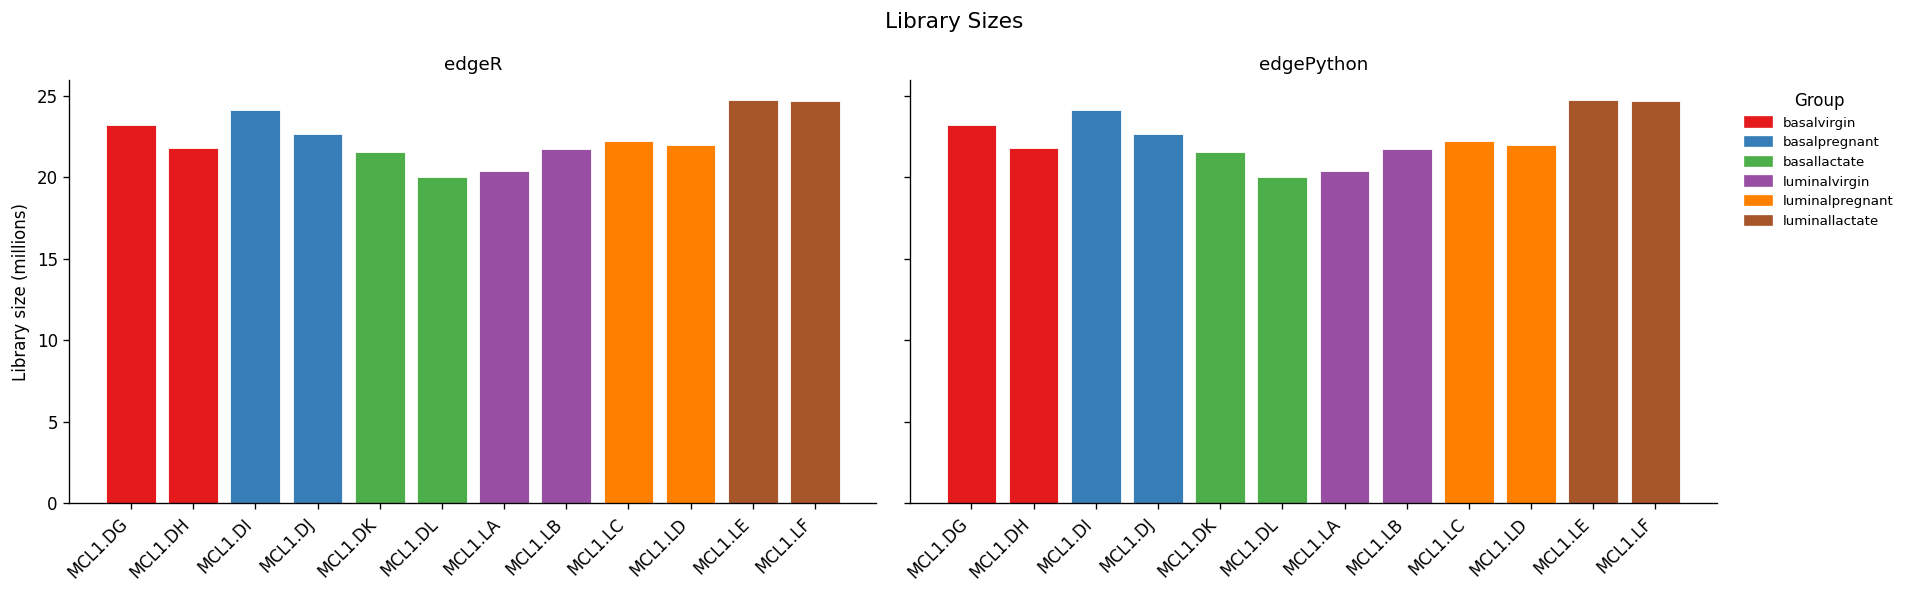

In [4]:
# Both use same raw counts, so library sizes are identical;
# we show them side-by-side to confirm and for visual reference.
r_lib = r_norm['lib.size'].values / 1e6
py_lib = d['samples']['lib.size'].values / 1e6

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
for ax, lib, title in [(ax1, r_lib, 'edgeR'), (ax2, py_lib, 'edgePython')]:
    colors = [group_colors[g] for g in group]
    ax.bar(range(len(lib)), lib, color=colors, edgecolor='white', linewidth=0.5)
    ax.set_xticks(range(len(sample_names)))
    ax.set_xticklabels(sample_names, rotation=45, ha='right')
    ax.set_title(title)
ax1.set_ylabel('Library size (millions)')
# Shared y-axis via sharey
handles = [mpatches.Patch(color=group_colors[g], label=g) for g in group_colors]
ax2.legend(handles=handles, title='Group', bbox_to_anchor=(1.02, 1),
           loc='upper left', frameon=False, fontsize=8)
fig.suptitle('Library Sizes', fontsize=13)
plt.tight_layout()
plt.show()

## 4. Log-CPM Density

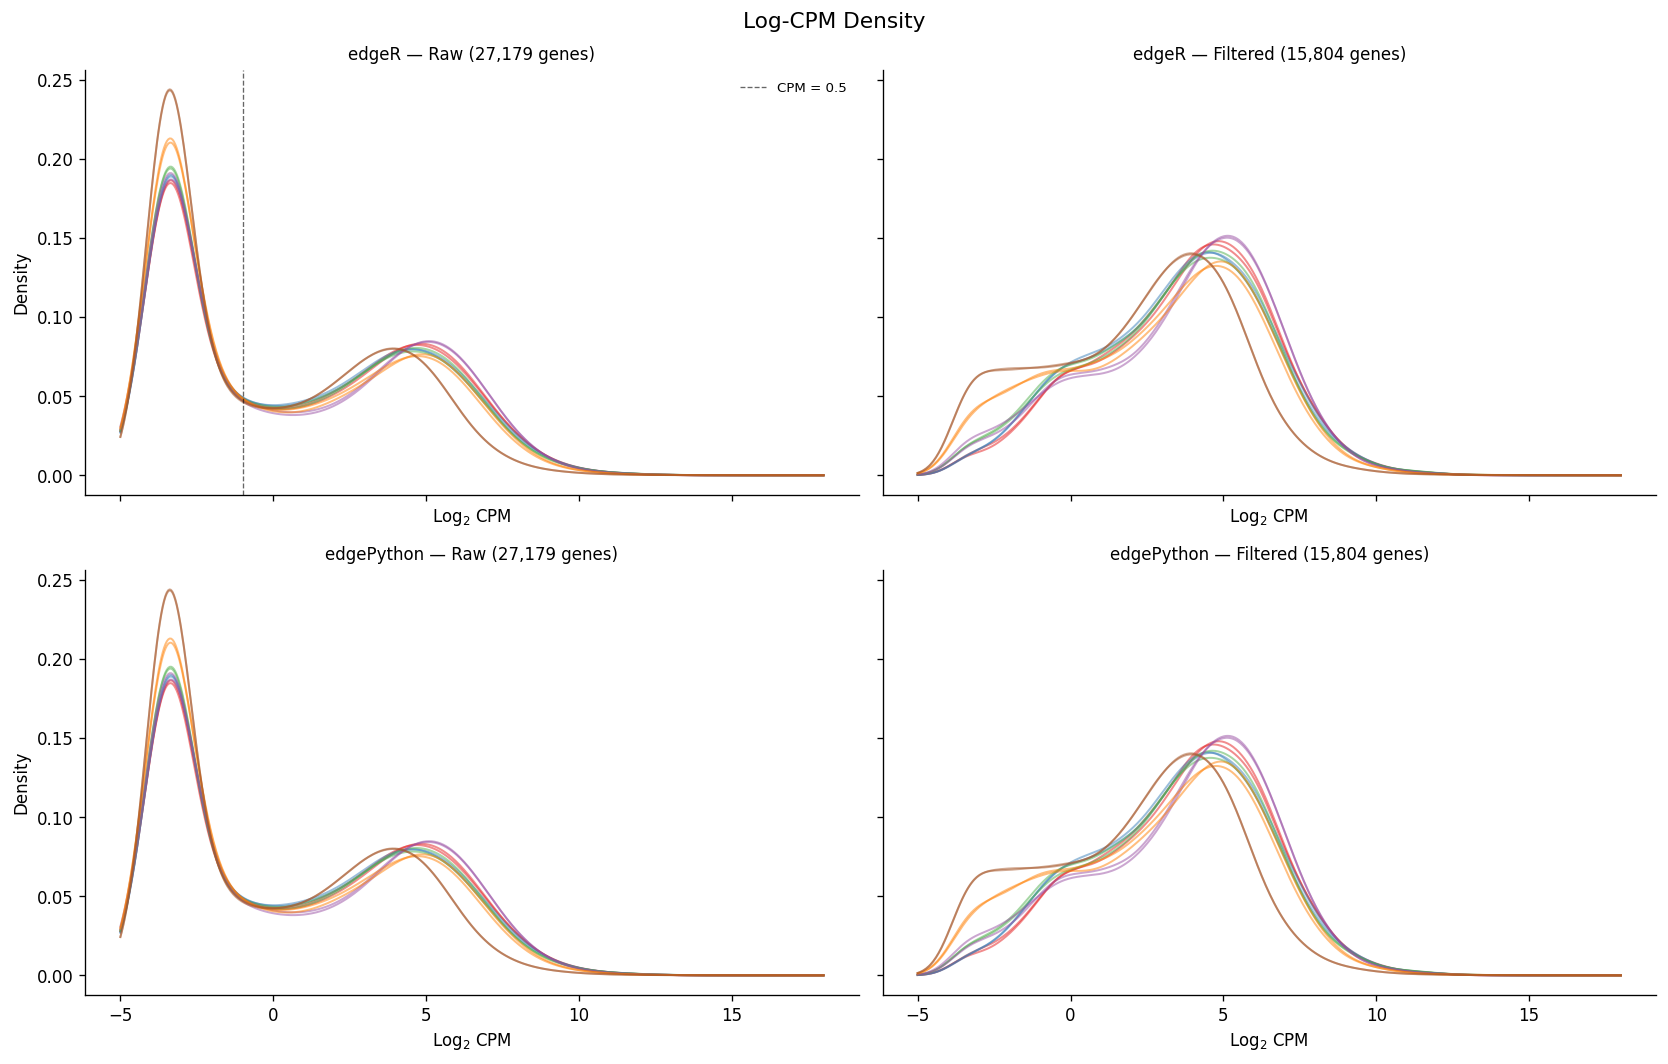

In [5]:
# Log-CPM density: R vs Python, before and after filtering
# R uses keep.lib.sizes=FALSE so filtered lib sizes are recomputed.
# R_norm_factors.csv contains the POST-FILTER lib sizes.
from scipy.stats import gaussian_kde

counts_all = counts_df.values.astype(float)

# --- Raw (before filtering): both R and Python use the same full-data lib sizes ---
raw_lib_size = counts_all.sum(axis=0)  # identical for R and Python
logcpm_raw = ep.cpm(counts_all, lib_size=raw_lib_size, log=True)

# --- Filtered (after filtering) ---
filt_counts = counts_all[keep, :]

# R filtered lib sizes (from R_norm_factors.csv, keep.lib.sizes=FALSE)
r_filt_lib = r_norm['lib.size'].values.astype(float)
logcpm_filt_r = ep.cpm(filt_counts, lib_size=r_filt_lib, log=True)

# Python filtered lib sizes (from d_filt, which also recomputes via make_dgelist)
py_filt_lib = d_filt['samples']['lib.size'].values
logcpm_filt_py = ep.cpm(filt_counts, lib_size=py_filt_lib, log=True)

# --- 2x2 figure: rows = R / Python, cols = Raw / Filtered ---
fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharex=True, sharey=True)
x_grid = np.linspace(-5, 18, 500)

panels = [
    (axes[0, 0], logcpm_raw,     f'edgeR — Raw ({counts_all.shape[0]:,} genes)'),
    (axes[0, 1], logcpm_filt_r,  f'edgeR — Filtered ({filt_counts.shape[0]:,} genes)'),
    (axes[1, 0], logcpm_raw,     f'edgePython — Raw ({counts_all.shape[0]:,} genes)'),
    (axes[1, 1], logcpm_filt_py, f'edgePython — Filtered ({filt_counts.shape[0]:,} genes)'),
]

for ax, data, title in panels:
    for j in range(data.shape[1]):
        c = group_colors[group[j]]
        kde = gaussian_kde(data[:, j], bw_method=0.2)
        ax.plot(x_grid, kde(x_grid), color=c, alpha=0.5, linewidth=1.2)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Log$_2$ CPM')

axes[0, 0].set_ylabel('Density')
axes[1, 0].set_ylabel('Density')
axes[0, 0].axvline(x=np.log2(0.5), color='black', linestyle='--', linewidth=0.8,
                    alpha=0.6, label='CPM = 0.5')
axes[0, 0].legend(frameon=False, fontsize=8)

fig.suptitle('Log-CPM Density', fontsize=13)
plt.tight_layout()
plt.show()

## 5. Log-CPM Boxplots (Before and After TMM Normalization)

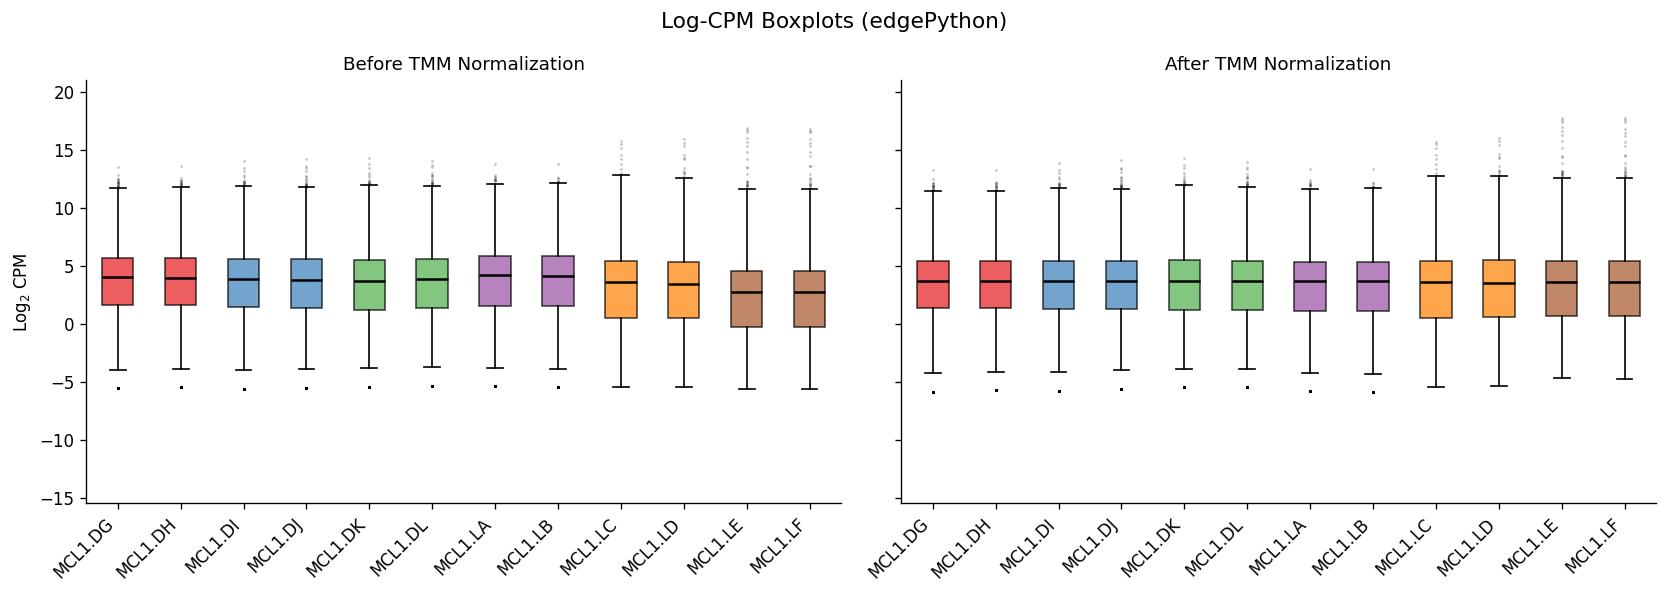

In [6]:
# R effective library sizes (lib.size * norm.factors)
r_lib_raw = r_norm['lib.size'].values
r_nf_vals = r_norm['norm.factors'].values
r_eff_lib = r_lib_raw * r_nf_vals

# Python
py_lib_raw = d_filt['samples']['lib.size'].values
py_nf_vals = d_filt['samples']['norm.factors'].values
py_eff_lib = py_lib_raw * py_nf_vals

# Compute log-CPM using R vs Python normalization factors
# (Both start from the same filtered counts)
filt_counts = d_filt['counts']

def logcpm_with_lib(counts, lib_sizes):
    """log2-CPM with given effective library sizes."""
    lib = lib_sizes / 1e6
    return np.log2(counts / lib[None, :] + 0.5 / lib[None, :])

# Before normalization: same for both (norm.factors = 1)
logcpm_unnorm = logcpm_with_lib(filt_counts, py_lib_raw)

# After normalization: R vs Python
logcpm_r_norm = logcpm_with_lib(filt_counts, r_eff_lib)
logcpm_py_norm = logcpm_with_lib(filt_counts, py_eff_lib)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Compute shared y-limits across all data
all_data = [logcpm_unnorm, logcpm_r_norm, logcpm_py_norm]
q1_min = min(np.percentile(d[:, i], 25) for d in all_data for i in range(d.shape[1]))
q3_max = max(np.percentile(d[:, i], 75) for d in all_data for i in range(d.shape[1]))
iqr = q3_max - q1_min
ylim = (q1_min - 2.5 * iqr, q3_max + 2.5 * iqr)

for ax, data_r, data_py, title in [
    (axes[0], logcpm_unnorm, logcpm_unnorm, 'Before TMM Normalization'),
    (axes[1], logcpm_r_norm, logcpm_py_norm, 'After TMM Normalization')]:
    # Show Python boxplot (R is nearly identical)
    bp = ax.boxplot([data_py[:, i] for i in range(data_py.shape[1])],
                    patch_artist=True, medianprops=dict(color='black', linewidth=1.5),
                    flierprops=dict(marker='.', markersize=1, alpha=0.3))
    for patch, g in zip(bp['boxes'], group):
        patch.set_facecolor(group_colors[g])
        patch.set_alpha(0.7)
    ax.set_xticklabels(sample_names, rotation=45, ha='right')
    ax.set_title(title)
    ax.set_ylim(ylim)
axes[0].set_ylabel('Log$_2$ CPM')
fig.suptitle('Log-CPM Boxplots (edgePython)', fontsize=13)
plt.tight_layout()
plt.show()

## 6. MDS Plot

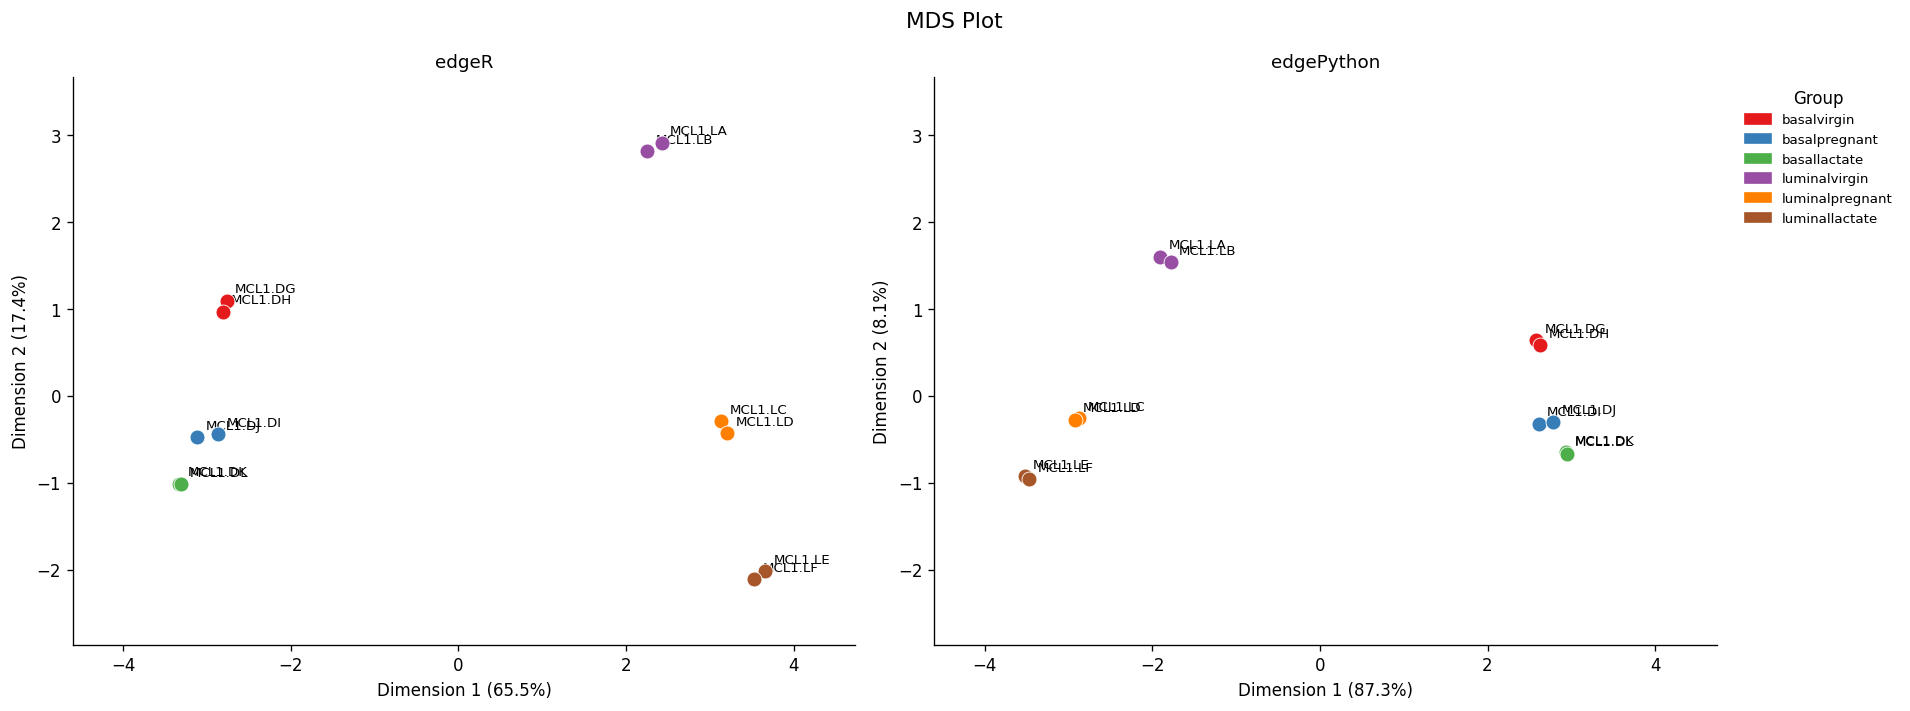

In [7]:
# --- R MDS coordinates (from pre-computed CSV) ---
r_mds_x = r_mds['MDS1'].values
r_mds_y = r_mds['MDS2'].values
r_var1 = r_mds['var.explained.1'].iloc[0] * 100  # to percentage
r_var2 = r_mds['var.explained.2'].iloc[0] * 100

# --- Python MDS coordinates (inline computation, same as ep.plot_mds) ---
counts_filt = d_filt['counts']
lib_size_mds = counts_filt.sum(axis=0)
log_cpm_mds = np.log2(counts_filt / lib_size_mds[None, :] * 1e6 + 0.5)
var_mds = np.var(log_cpm_mds, axis=1)
top_idx_mds = np.argsort(var_mds)[::-1][:500]
log_cpm_top = log_cpm_mds[top_idx_mds]

nsamples = counts_filt.shape[1]
dist_mat = np.zeros((nsamples, nsamples))
for i in range(nsamples):
    for j in range(i + 1, nsamples):
        dd = np.sqrt(np.mean((log_cpm_top[:, i] - log_cpm_top[:, j]) ** 2))
        dist_mat[i, j] = dd
        dist_mat[j, i] = dd

H = np.eye(nsamples) - np.ones((nsamples, nsamples)) / nsamples
B = -0.5 * H @ (dist_mat ** 2) @ H
eigvals, eigvecs = np.linalg.eigh(B)
idx_sort = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx_sort]
eigvecs = eigvecs[:, idx_sort]

py_mds_x = eigvecs[:, 0] * np.sqrt(max(eigvals[0], 0))
py_mds_y = eigvecs[:, 1] * np.sqrt(max(eigvals[1], 0))
total_var = np.sum(np.maximum(eigvals, 0))
py_var1 = max(eigvals[0], 0) / total_var * 100
py_var2 = max(eigvals[1], 0) / total_var * 100

# --- Shared axis bounds ---
all_x_mds = np.concatenate([r_mds_x, py_mds_x])
all_y_mds = np.concatenate([r_mds_y, py_mds_y])
x_margin = (all_x_mds.max() - all_x_mds.min()) * 0.15
y_margin = (all_y_mds.max() - all_y_mds.min()) * 0.15
x_lim_mds = (all_x_mds.min() - x_margin, all_x_mds.max() + x_margin)
y_lim_mds = (all_y_mds.min() - y_margin, all_y_mds.max() + y_margin)

# --- Side-by-side plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for ax, mx, my, v1, v2, title in [
    (ax1, r_mds_x, r_mds_y, r_var1, r_var2, 'edgeR'),
    (ax2, py_mds_x, py_mds_y, py_var1, py_var2, 'edgePython')]:
    for i in range(len(mx)):
        ax.scatter(mx[i], my[i], c=group_colors[group[i]], s=80,
                   edgecolors='white', linewidth=0.5, zorder=5)
        ax.annotate(sample_names[i], (mx[i], my[i]),
                    fontsize=8, ha='left', va='bottom',
                    xytext=(5, 3), textcoords='offset points')
    ax.set_xlabel(f'Dimension 1 ({v1:.1f}%)')
    ax.set_ylabel(f'Dimension 2 ({v2:.1f}%)')
    ax.set_title(title)
    ax.set_xlim(x_lim_mds)
    ax.set_ylim(y_lim_mds)

handles = [mpatches.Patch(color=group_colors[g], label=g) for g in group_colors]
ax2.legend(handles=handles, title='Group', bbox_to_anchor=(1.02, 1),
           loc='upper left', frameon=False, fontsize=8)
fig.suptitle('MDS Plot', fontsize=13)
plt.tight_layout()
plt.show()

## 7. BCV Plot (Biological Coefficient of Variation)

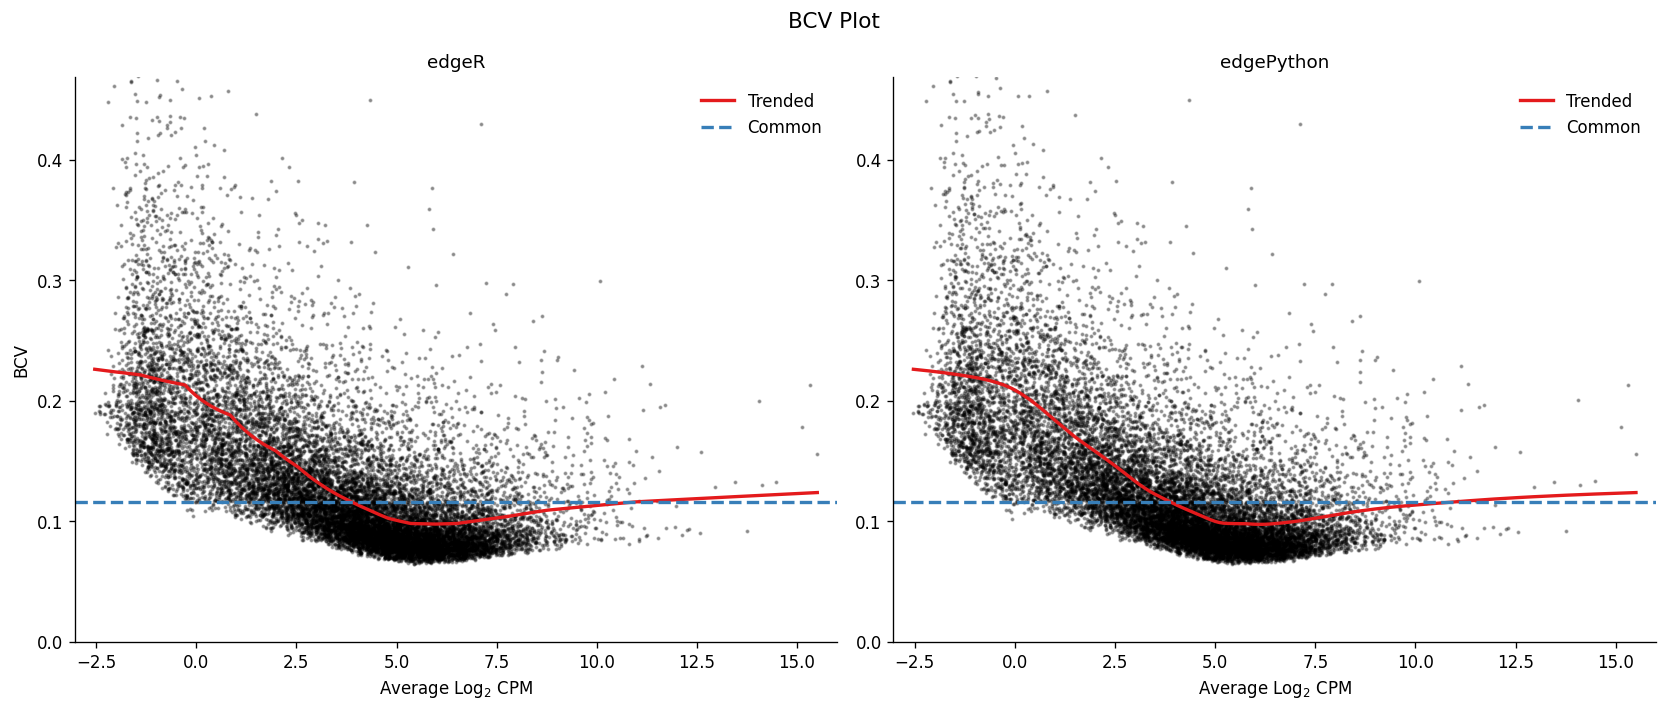

In [8]:
# Python data
py_logcpm = d_filt['AveLogCPM'] if 'AveLogCPM' in d_filt else ep.ave_log_cpm(d_filt)
py_tagwise_all = d_filt['tagwise.dispersion']
py_trended_all = d_filt['trended.dispersion']
py_common_disp = d_filt['common.dispersion']

# R data (aligned to Python gene order)
r_disp_idx = r_disp.set_index('GeneID')
py_gene_order = d_filt['genes']['GeneID'].values
mask_r = np.array([g in r_disp_idx.index for g in py_gene_order])
r_genes_in_py = py_gene_order[mask_r]
r_tw_aligned = r_disp_idx.loc[r_genes_in_py, 'tagwise.dispersion'].values
r_tr_aligned = r_disp_idx.loc[r_genes_in_py, 'trended.dispersion'].values
r_common_val = r_disp_idx.loc[r_genes_in_py, 'common.dispersion'].values[0]
r_logcpm_bcv = py_logcpm[mask_r]

# Shared axis bounds
all_bcv = np.concatenate([np.sqrt(r_tw_aligned), np.sqrt(py_tagwise_all)])
all_x = np.concatenate([r_logcpm_bcv, py_logcpm])
x_lim = (all_x.min() - 0.5, all_x.max() + 0.5)
y_lim = (0, np.percentile(all_bcv, 99.5) * 1.1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

order_r = np.argsort(r_logcpm_bcv)
ax1.scatter(r_logcpm_bcv, np.sqrt(r_tw_aligned), s=2, alpha=0.3, color='black', rasterized=True)
ax1.plot(r_logcpm_bcv[order_r], np.sqrt(r_tr_aligned[order_r]), color='#E41A1C', lw=2, label='Trended')
ax1.axhline(y=np.sqrt(r_common_val), color='#377EB8', lw=2, linestyle='--', label='Common')
ax1.set_xlabel('Average Log$_2$ CPM'); ax1.set_ylabel('BCV')
ax1.set_title('edgeR'); ax1.legend(frameon=False)
ax1.set_xlim(x_lim); ax1.set_ylim(y_lim)

order_py = np.argsort(py_logcpm)
ax2.scatter(py_logcpm, np.sqrt(py_tagwise_all), s=2, alpha=0.3, color='black', rasterized=True)
ax2.plot(py_logcpm[order_py], np.sqrt(py_trended_all[order_py]), color='#E41A1C', lw=2, label='Trended')
ax2.axhline(y=np.sqrt(py_common_disp), color='#377EB8', lw=2, linestyle='--', label='Common')
ax2.set_xlabel('Average Log$_2$ CPM')
ax2.set_title('edgePython'); ax2.legend(frameon=False)
ax2.set_xlim(x_lim); ax2.set_ylim(y_lim)

fig.suptitle('BCV Plot', fontsize=13)
plt.tight_layout()
plt.show()

## 8. Quasi-Likelihood Dispersion Plot

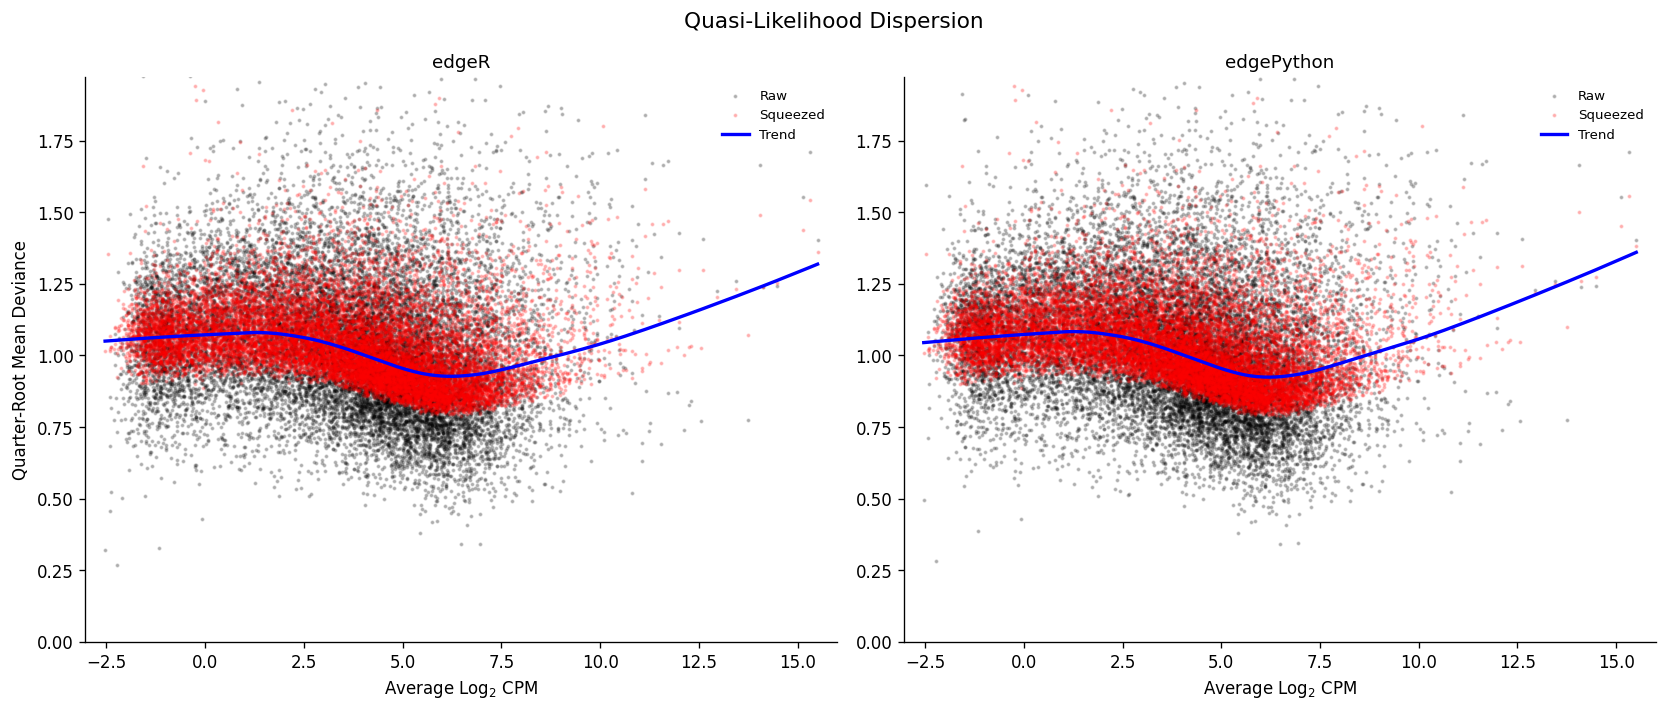

In [9]:
# R QL dispersion data (proper s2.raw, s2.post, s2.prior from glmQLFit)
r_ql = r_ql_disp.set_index('GeneID')
r_ql_genes = r_ql.index.intersection(pd.Index(d_filt['genes']['GeneID'].values))

r_s2_raw = r_ql.loc[r_ql_genes, 's2.raw'].values
r_s2_post = r_ql.loc[r_ql_genes, 's2.post'].values
r_s2_prior = r_ql.loc[r_ql_genes, 's2.prior'].values
r_logcpm_ql = r_ql.loc[r_ql_genes, 'AveLogCPM'].values

# Python QL dispersion data
py_logcpm_ql = fit['AveLogCPM']
py_df_res = np.asarray(fit.get('df.residual.adj', fit['df.residual']), dtype=np.float64)
py_dev = np.asarray(fit.get('deviance.adj', fit['deviance']), dtype=np.float64)
py_s2_raw = py_dev / np.maximum(py_df_res, 1e-8)
py_s2_raw[py_df_res < 1e-8] = 0
py_s2_post = fit['s2.post']
py_s2_prior = fit['s2.prior']

# Shared axis bounds (use quarter-root scale as in plotQLDisp)
all_raw = np.concatenate([r_s2_raw ** 0.25, py_s2_raw ** 0.25])
all_x_ql = np.concatenate([r_logcpm_ql, py_logcpm_ql])
x_lim_ql = (all_x_ql.min() - 0.5, all_x_ql.max() + 0.5)
y_lim_ql = (0, np.percentile(all_raw[all_raw > 0], 99.5) * 1.1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# R panel: raw (black), squeezed (red), trend (blue)
order_r = np.argsort(r_logcpm_ql)
ax1.scatter(r_logcpm_ql, r_s2_raw ** 0.25, s=2, alpha=0.2, color='black', rasterized=True, label='Raw')
ax1.scatter(r_logcpm_ql, r_s2_post ** 0.25, s=2, alpha=0.2, color='red', rasterized=True, label='Squeezed')
ax1.plot(r_logcpm_ql[order_r], r_s2_prior[order_r] ** 0.25, color='blue', lw=2, label='Trend')
ax1.set_xlabel('Average Log$_2$ CPM'); ax1.set_ylabel('Quarter-Root Mean Deviance')
ax1.set_title('edgeR'); ax1.legend(frameon=False, fontsize=8)
ax1.set_xlim(x_lim_ql); ax1.set_ylim(y_lim_ql)

# Python panel
order_py = np.argsort(py_logcpm_ql)
ax2.scatter(py_logcpm_ql, py_s2_raw ** 0.25, s=2, alpha=0.2, color='black', rasterized=True, label='Raw')
ax2.scatter(py_logcpm_ql, py_s2_post ** 0.25, s=2, alpha=0.2, color='red', rasterized=True, label='Squeezed')
ax2.plot(py_logcpm_ql[order_py], py_s2_prior[order_py] ** 0.25, color='blue', lw=2, label='Trend')
ax2.set_xlabel('Average Log$_2$ CPM')
ax2.set_title('edgePython'); ax2.legend(frameon=False, fontsize=8)
ax2.set_xlim(x_lim_ql); ax2.set_ylim(y_lim_ql)

fig.suptitle('Quasi-Likelihood Dispersion', fontsize=13)
plt.tight_layout()
plt.show()

## 9. MD Plots (Mean-Difference)

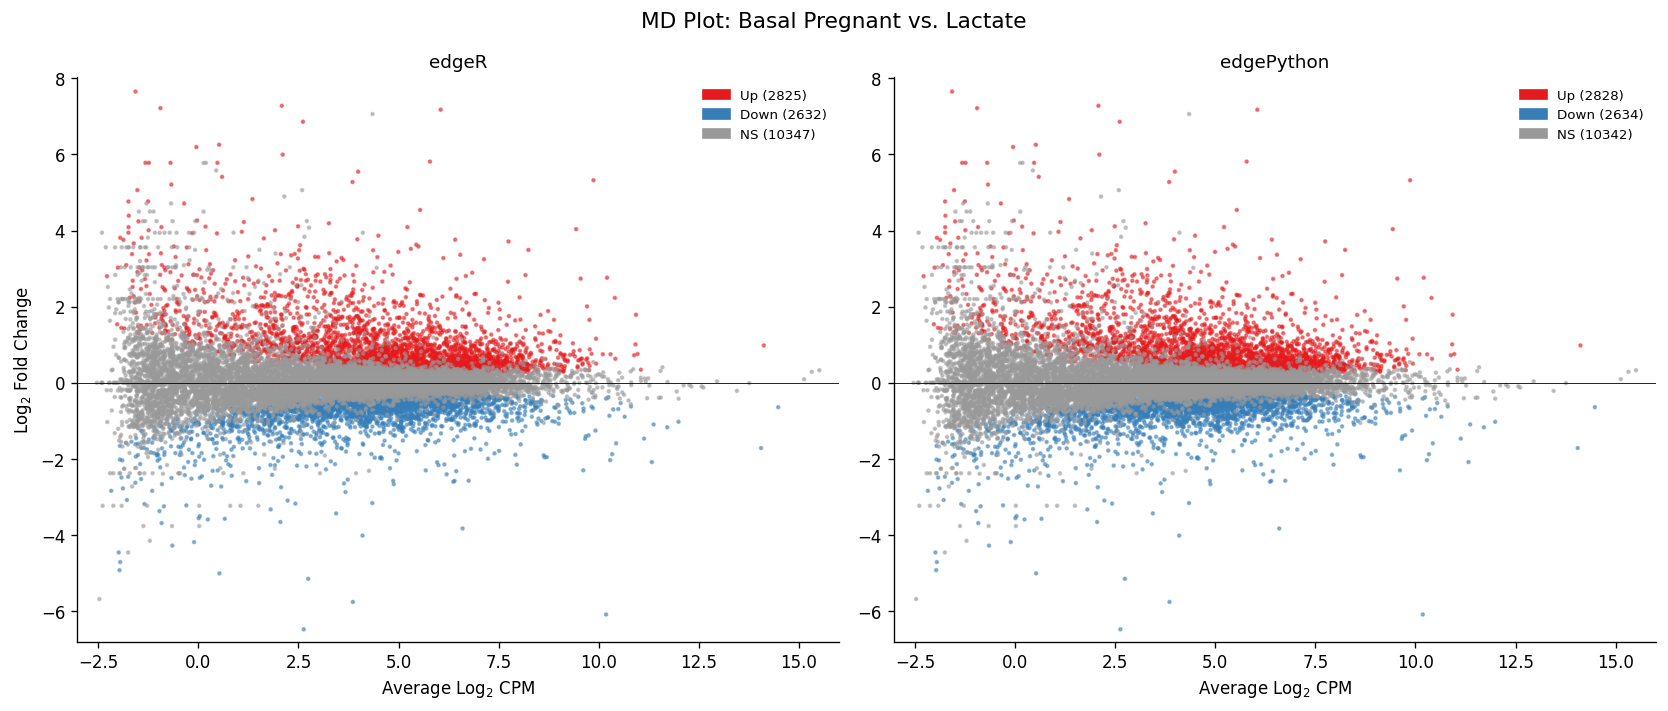

In [10]:
# Align R and Python QLF results
r_b = r_qlf_basal.set_index('GeneID')
py_b = py_qlf_basal.set_index('GeneID')
common_md = r_b.index.astype(str).intersection(py_b.index.astype(str))

r_logfc_b = r_b.loc[common_md, 'logFC'].values.astype(float)
r_logcpm_b = r_b.loc[common_md, 'logCPM'].values.astype(float)
r_fdr_b = r_b.loc[common_md, 'FDR'].values.astype(float)
r_sig_b = r_fdr_b < 0.05
py_logfc_b = py_b.loc[common_md, 'logFC'].values.astype(float)
py_logcpm_b = py_b.loc[common_md, 'logCPM'].values.astype(float)
py_fdr_b = py_b.loc[common_md, 'FDR'].values.astype(float)
py_sig_b = py_fdr_b < 0.05

# Shared bounds for basal
x_lim_md_b = (min(r_logcpm_b.min(), py_logcpm_b.min()) - 0.5,
              max(r_logcpm_b.max(), py_logcpm_b.max()) + 0.5)
y_lim_md_b = (min(r_logfc_b.min(), py_logfc_b.min()) * 1.05,
              max(r_logfc_b.max(), py_logfc_b.max()) * 1.05)

r_colors_b = np.where(r_sig_b & (r_logfc_b > 0), '#E41A1C',
              np.where(r_sig_b & (r_logfc_b < 0), '#377EB8', '#999999'))
py_colors_b = np.where(py_sig_b & (py_logfc_b > 0), '#E41A1C',
               np.where(py_sig_b & (py_logfc_b < 0), '#377EB8', '#999999'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# R
r_up_b = int(np.sum(r_sig_b & (r_logfc_b > 0)))
r_dn_b = int(np.sum(r_sig_b & (r_logfc_b < 0)))
r_ns_b = int(np.sum(~r_sig_b))
ax1.scatter(r_logcpm_b, r_logfc_b, c=r_colors_b, s=3, alpha=0.5, rasterized=True)
ax1.axhline(y=0, color='black', linewidth=0.5)
ax1.set_xlabel('Average Log$_2$ CPM'); ax1.set_ylabel('Log$_2$ Fold Change')
ax1.set_title('edgeR')
ax1.legend(handles=[mpatches.Patch(color='#E41A1C', label=f'Up ({r_up_b})'),
                     mpatches.Patch(color='#377EB8', label=f'Down ({r_dn_b})'),
                     mpatches.Patch(color='#999999', label=f'NS ({r_ns_b})')],
           loc='upper right', frameon=False, fontsize=8)
ax1.set_xlim(x_lim_md_b); ax1.set_ylim(y_lim_md_b)

# Python
py_up_b = int(np.sum(py_sig_b & (py_logfc_b > 0)))
py_dn_b = int(np.sum(py_sig_b & (py_logfc_b < 0)))
py_ns_b = int(np.sum(~py_sig_b))
ax2.scatter(py_logcpm_b, py_logfc_b, c=py_colors_b, s=3, alpha=0.5, rasterized=True)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_xlabel('Average Log$_2$ CPM')
ax2.set_title('edgePython')
ax2.legend(handles=[mpatches.Patch(color='#E41A1C', label=f'Up ({py_up_b})'),
                     mpatches.Patch(color='#377EB8', label=f'Down ({py_dn_b})'),
                     mpatches.Patch(color='#999999', label=f'NS ({py_ns_b})')],
           loc='upper right', frameon=False, fontsize=8)
ax2.set_xlim(x_lim_md_b); ax2.set_ylim(y_lim_md_b)

fig.suptitle('MD Plot: Basal Pregnant vs. Lactate', fontsize=13)
plt.tight_layout()
plt.show()

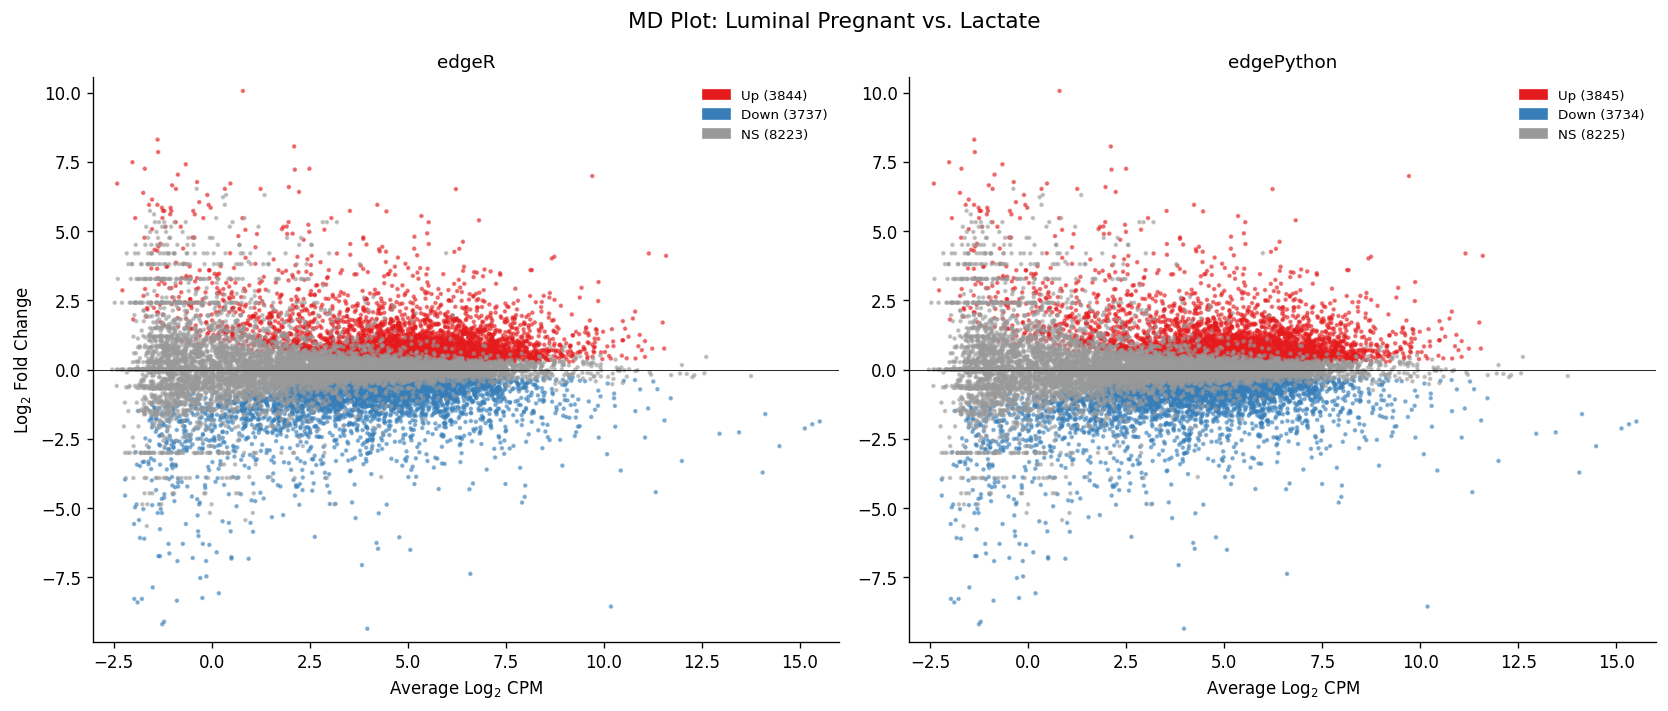

In [11]:
# Luminal contrast
r_l = r_qlf_luminal.set_index('GeneID')
py_l = py_qlf_luminal.set_index('GeneID')
common_md_l = r_l.index.astype(str).intersection(py_l.index.astype(str))

r_logfc_l = r_l.loc[common_md_l, 'logFC'].values.astype(float)
r_logcpm_l = r_l.loc[common_md_l, 'logCPM'].values.astype(float)
r_fdr_l = r_l.loc[common_md_l, 'FDR'].values.astype(float)
r_sig_l = r_fdr_l < 0.05
py_logfc_l = py_l.loc[common_md_l, 'logFC'].values.astype(float)
py_logcpm_l = py_l.loc[common_md_l, 'logCPM'].values.astype(float)
py_fdr_l = py_l.loc[common_md_l, 'FDR'].values.astype(float)
py_sig_l = py_fdr_l < 0.05

x_lim_md_l = (min(r_logcpm_l.min(), py_logcpm_l.min()) - 0.5,
              max(r_logcpm_l.max(), py_logcpm_l.max()) + 0.5)
y_lim_md_l = (min(r_logfc_l.min(), py_logfc_l.min()) * 1.05,
              max(r_logfc_l.max(), py_logfc_l.max()) * 1.05)

r_colors_l = np.where(r_sig_l & (r_logfc_l > 0), '#E41A1C',
              np.where(r_sig_l & (r_logfc_l < 0), '#377EB8', '#999999'))
py_colors_l = np.where(py_sig_l & (py_logfc_l > 0), '#E41A1C',
               np.where(py_sig_l & (py_logfc_l < 0), '#377EB8', '#999999'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

r_up_l = int(np.sum(r_sig_l & (r_logfc_l > 0)))
r_dn_l = int(np.sum(r_sig_l & (r_logfc_l < 0)))
r_ns_l = int(np.sum(~r_sig_l))
ax1.scatter(r_logcpm_l, r_logfc_l, c=r_colors_l, s=3, alpha=0.5, rasterized=True)
ax1.axhline(y=0, color='black', linewidth=0.5)
ax1.set_xlabel('Average Log$_2$ CPM'); ax1.set_ylabel('Log$_2$ Fold Change')
ax1.set_title('edgeR')
ax1.legend(handles=[mpatches.Patch(color='#E41A1C', label=f'Up ({r_up_l})'),
                     mpatches.Patch(color='#377EB8', label=f'Down ({r_dn_l})'),
                     mpatches.Patch(color='#999999', label=f'NS ({r_ns_l})')],
           loc='upper right', frameon=False, fontsize=8)
ax1.set_xlim(x_lim_md_l); ax1.set_ylim(y_lim_md_l)

py_up_l = int(np.sum(py_sig_l & (py_logfc_l > 0)))
py_dn_l = int(np.sum(py_sig_l & (py_logfc_l < 0)))
py_ns_l = int(np.sum(~py_sig_l))
ax2.scatter(py_logcpm_l, py_logfc_l, c=py_colors_l, s=3, alpha=0.5, rasterized=True)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_xlabel('Average Log$_2$ CPM')
ax2.set_title('edgePython')
ax2.legend(handles=[mpatches.Patch(color='#E41A1C', label=f'Up ({py_up_l})'),
                     mpatches.Patch(color='#377EB8', label=f'Down ({py_dn_l})'),
                     mpatches.Patch(color='#999999', label=f'NS ({py_ns_l})')],
           loc='upper right', frameon=False, fontsize=8)
ax2.set_xlim(x_lim_md_l); ax2.set_ylim(y_lim_md_l)

fig.suptitle('MD Plot: Luminal Pregnant vs. Lactate', fontsize=13)
plt.tight_layout()
plt.show()

## 10. Volcano Plots

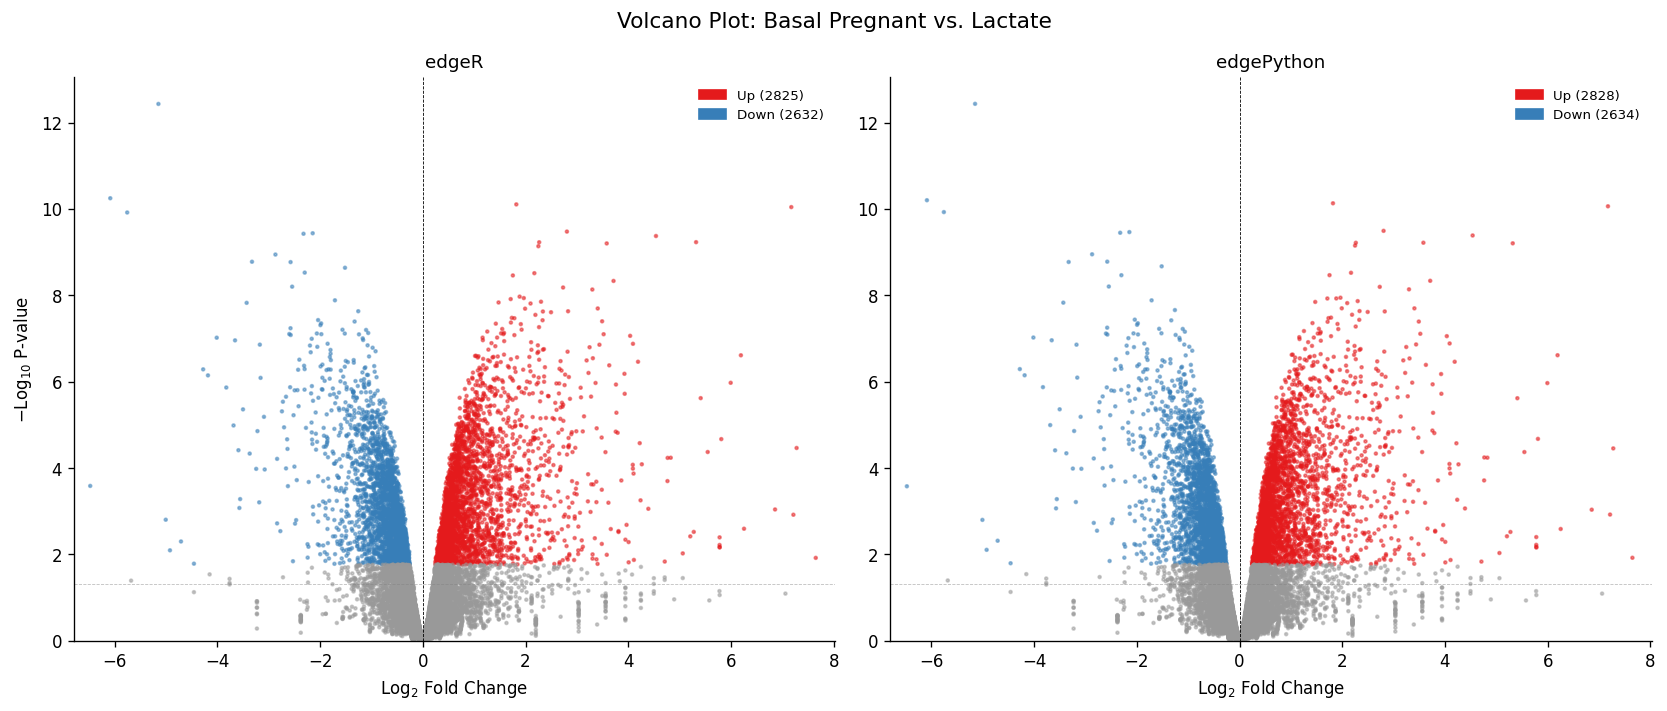

In [12]:
# Basal
r_neglogp_b = -np.log10(np.maximum(r_b.loc[common_md, 'PValue'].values.astype(float), 1e-300))
py_neglogp_b = -np.log10(np.maximum(py_b.loc[common_md, 'PValue'].values.astype(float), 1e-300))

x_lim_v_b = (min(r_logfc_b.min(), py_logfc_b.min()) * 1.05,
             max(r_logfc_b.max(), py_logfc_b.max()) * 1.05)
y_lim_v_b = (0, max(r_neglogp_b.max(), py_neglogp_b.max()) * 1.05)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(r_logfc_b, r_neglogp_b, c=r_colors_b, s=3, alpha=0.5, rasterized=True)
ax1.axvline(x=0, color='black', linewidth=0.5, linestyle='--')
ax1.axhline(y=-np.log10(0.05), color='grey', linewidth=0.5, linestyle='--', alpha=0.5)
ax1.set_xlabel('Log$_2$ Fold Change'); ax1.set_ylabel('$-$Log$_{10}$ P-value')
ax1.set_title('edgeR')
ax1.legend(handles=[mpatches.Patch(color='#E41A1C', label=f'Up ({r_up_b})'),
                     mpatches.Patch(color='#377EB8', label=f'Down ({r_dn_b})')],
           loc='upper right', frameon=False, fontsize=8)
ax1.set_xlim(x_lim_v_b); ax1.set_ylim(y_lim_v_b)

ax2.scatter(py_logfc_b, py_neglogp_b, c=py_colors_b, s=3, alpha=0.5, rasterized=True)
ax2.axvline(x=0, color='black', linewidth=0.5, linestyle='--')
ax2.axhline(y=-np.log10(0.05), color='grey', linewidth=0.5, linestyle='--', alpha=0.5)
ax2.set_xlabel('Log$_2$ Fold Change')
ax2.set_title('edgePython')
ax2.legend(handles=[mpatches.Patch(color='#E41A1C', label=f'Up ({py_up_b})'),
                     mpatches.Patch(color='#377EB8', label=f'Down ({py_dn_b})')],
           loc='upper right', frameon=False, fontsize=8)
ax2.set_xlim(x_lim_v_b); ax2.set_ylim(y_lim_v_b)

fig.suptitle('Volcano Plot: Basal Pregnant vs. Lactate', fontsize=13)
plt.tight_layout()
plt.show()

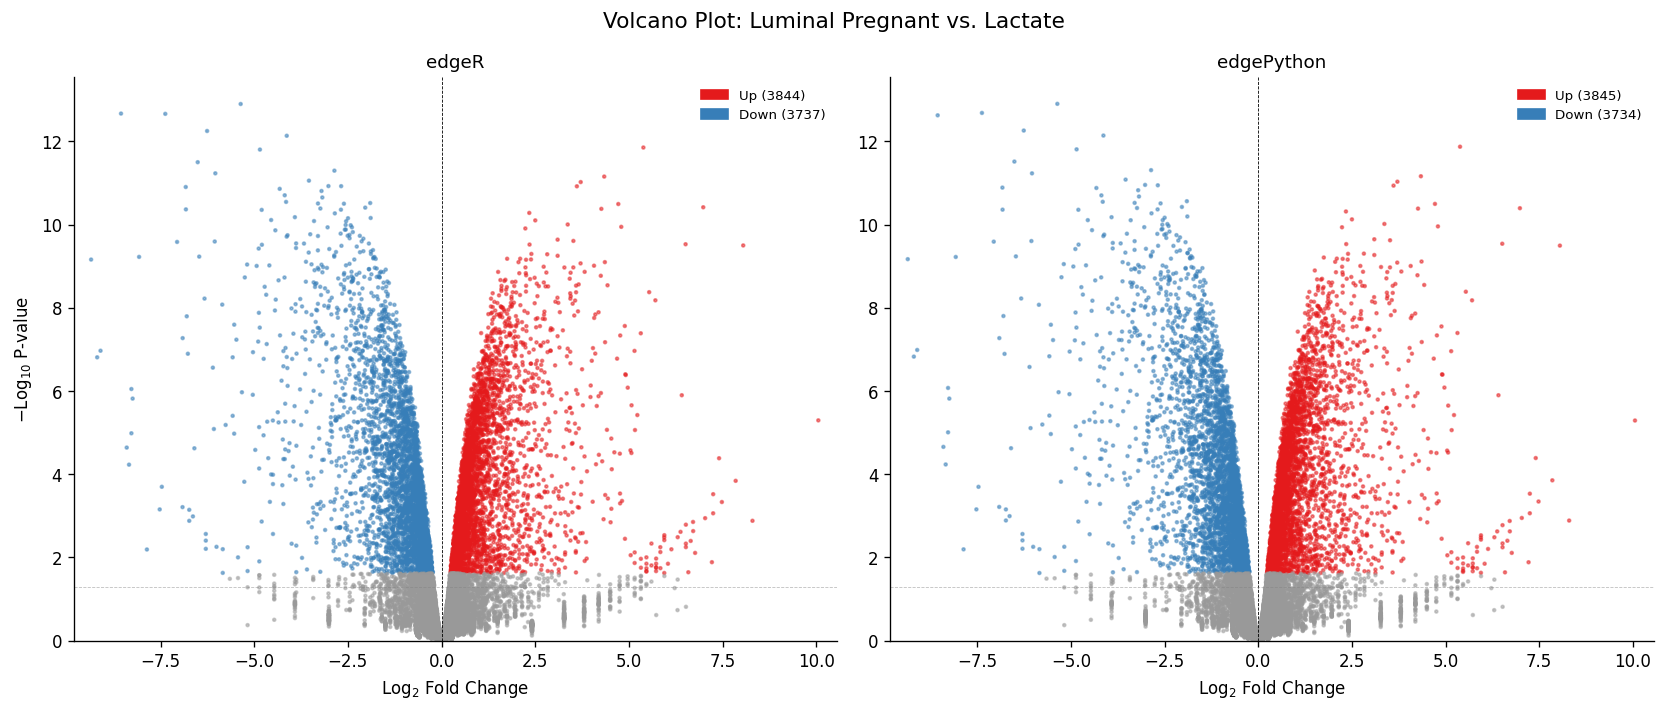

In [13]:
# Luminal
r_neglogp_l = -np.log10(np.maximum(r_l.loc[common_md_l, 'PValue'].values.astype(float), 1e-300))
py_neglogp_l = -np.log10(np.maximum(py_l.loc[common_md_l, 'PValue'].values.astype(float), 1e-300))

x_lim_v_l = (min(r_logfc_l.min(), py_logfc_l.min()) * 1.05,
             max(r_logfc_l.max(), py_logfc_l.max()) * 1.05)
y_lim_v_l = (0, max(r_neglogp_l.max(), py_neglogp_l.max()) * 1.05)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(r_logfc_l, r_neglogp_l, c=r_colors_l, s=3, alpha=0.5, rasterized=True)
ax1.axvline(x=0, color='black', linewidth=0.5, linestyle='--')
ax1.axhline(y=-np.log10(0.05), color='grey', linewidth=0.5, linestyle='--', alpha=0.5)
ax1.set_xlabel('Log$_2$ Fold Change'); ax1.set_ylabel('$-$Log$_{10}$ P-value')
ax1.set_title('edgeR')
ax1.legend(handles=[mpatches.Patch(color='#E41A1C', label=f'Up ({r_up_l})'),
                     mpatches.Patch(color='#377EB8', label=f'Down ({r_dn_l})')],
           loc='upper right', frameon=False, fontsize=8)
ax1.set_xlim(x_lim_v_l); ax1.set_ylim(y_lim_v_l)

ax2.scatter(py_logfc_l, py_neglogp_l, c=py_colors_l, s=3, alpha=0.5, rasterized=True)
ax2.axvline(x=0, color='black', linewidth=0.5, linestyle='--')
ax2.axhline(y=-np.log10(0.05), color='grey', linewidth=0.5, linestyle='--', alpha=0.5)
ax2.set_xlabel('Log$_2$ Fold Change')
ax2.set_title('edgePython')
ax2.legend(handles=[mpatches.Patch(color='#E41A1C', label=f'Up ({py_up_l})'),
                     mpatches.Patch(color='#377EB8', label=f'Down ({py_dn_l})')],
           loc='upper right', frameon=False, fontsize=8)
ax2.set_xlim(x_lim_v_l); ax2.set_ylim(y_lim_v_l)

fig.suptitle('Volcano Plot: Luminal Pregnant vs. Lactate', fontsize=13)
plt.tight_layout()
plt.show()

## 11. Number of Differentially Expressed Genes

In [14]:
# DE gene counts: QL F-test (FDR < 0.05) and TREAT (|logFC| > 0.58, FDR < 0.05)
r_treat_b_fdr = r_treat_basal.set_index('GeneID')['FDR'].astype(float)
r_treat_b_lfc = r_treat_basal.set_index('GeneID')['logFC'].astype(float)
r_treat_l_fdr = r_treat_luminal.set_index('GeneID')['FDR'].astype(float)
r_treat_l_lfc = r_treat_luminal.set_index('GeneID')['logFC'].astype(float)

py_treat_b_fdr = py_treat_basal.set_index('GeneID')['FDR'].astype(float)
py_treat_b_lfc = py_treat_basal.set_index('GeneID')['logFC'].astype(float)
py_treat_l_fdr = py_treat_luminal.set_index('GeneID')['FDR'].astype(float)
py_treat_l_lfc = py_treat_luminal.set_index('GeneID')['logFC'].astype(float)

de_summary = pd.DataFrame({
    'Contrast': [
        'Basal: P vs L', 'Basal: P vs L',
        'Luminal: P vs L', 'Luminal: P vs L',
    ],
    'Method': [
        'QL F-test (FDR < 0.05)', 'TREAT |logFC| > 0.58',
        'QL F-test (FDR < 0.05)', 'TREAT |logFC| > 0.58',
    ],
    'R Up': [
        r_up_b,
        int(np.sum((r_treat_b_fdr < 0.05) & (r_treat_b_lfc > 0))),
        r_up_l,
        int(np.sum((r_treat_l_fdr < 0.05) & (r_treat_l_lfc > 0))),
    ],
    'R Down': [
        r_dn_b,
        int(np.sum((r_treat_b_fdr < 0.05) & (r_treat_b_lfc < 0))),
        r_dn_l,
        int(np.sum((r_treat_l_fdr < 0.05) & (r_treat_l_lfc < 0))),
    ],
    'Python Up': [
        py_up_b,
        int(np.sum((py_treat_b_fdr < 0.05) & (py_treat_b_lfc > 0))),
        py_up_l,
        int(np.sum((py_treat_l_fdr < 0.05) & (py_treat_l_lfc > 0))),
    ],
    'Python Down': [
        py_dn_b,
        int(np.sum((py_treat_b_fdr < 0.05) & (py_treat_b_lfc < 0))),
        py_dn_l,
        int(np.sum((py_treat_l_fdr < 0.05) & (py_treat_l_lfc < 0))),
    ],
})
de_summary['R Total'] = de_summary['R Up'] + de_summary['R Down']
de_summary['Python Total'] = de_summary['Python Up'] + de_summary['Python Down']
de_summary

print('DE gene counts (R vs Python):')
print(de_summary.to_string(index=False))
de_summary


DE gene counts (R vs Python):
       Contrast                 Method  R Up  R Down  Python Up  Python Down  R Total  Python Total
  Basal: P vs L QL F-test (FDR < 0.05)  2825    2632       2828         2634     5457          5462
  Basal: P vs L   TREAT |logFC| > 0.58   709     414        709          414     1123          1123
Luminal: P vs L QL F-test (FDR < 0.05)  3844    3737       3845         3734     7581          7579
Luminal: P vs L   TREAT |logFC| > 0.58  1559    1749       1556         1750     3308          3306


,Contrast,Method,R Up,R Down,Python Up,Python Down,R Total,Python Total
0,Basal: P vs L,QL F-test (FDR < 0.05),2825,2632,2828,2634,5457,5462
1,Basal: P vs L,TREAT |logFC| > 0.58,709,414,709,414,1123,1123
2,Luminal: P vs L,QL F-test (FDR < 0.05),3844,3737,3845,3734,7581,7579
3,Luminal: P vs L,TREAT |logFC| > 0.58,1559,1749,1556,1750,3308,3306


## 12. Heatmap of Top 50 DE Genes

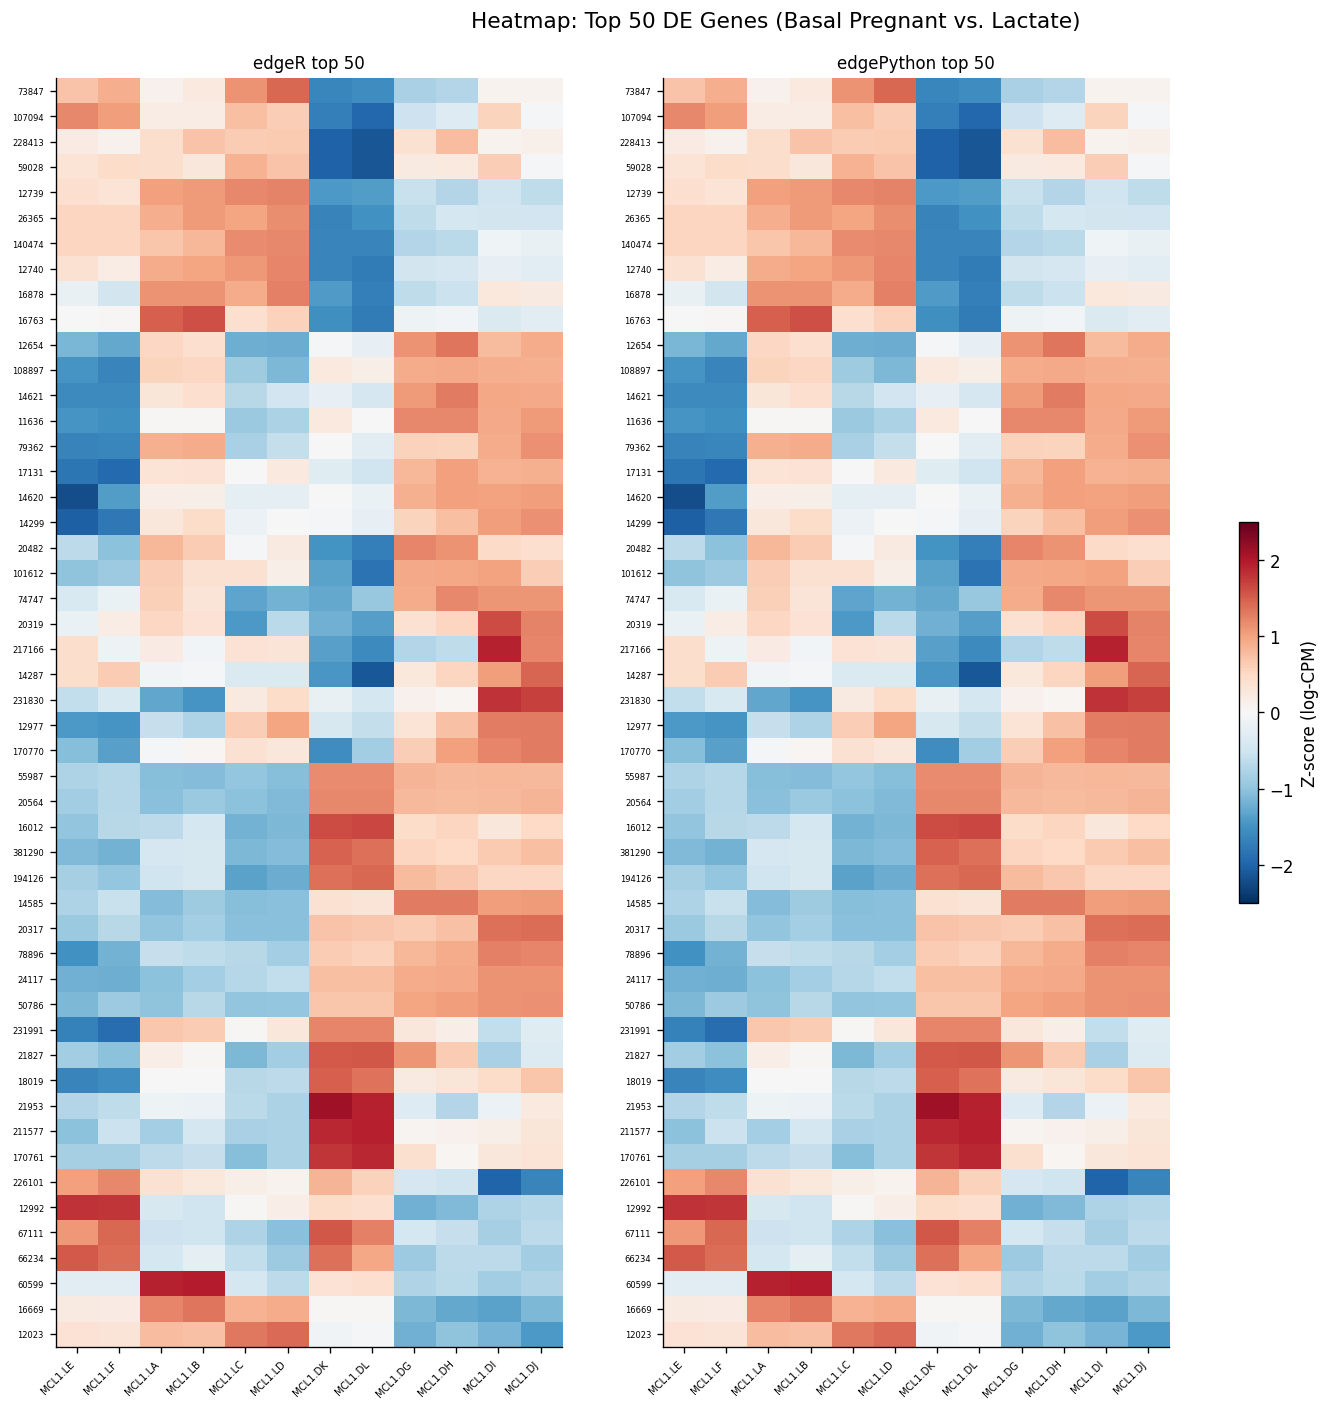

In [15]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

logcpm_all = ep.cpm(d_filt, log=True)
gene_id_filt = d_filt['genes']['GeneID'].values
gene_id_to_idx = {gid: i for i, gid in enumerate(gene_id_filt)}

def make_heatmap(ax, top_genes_df, title, logcpm_mat, gene_lookup,
                 row_link=None, col_link=None):
    """Draw a clustered heatmap on the given axes."""
    top_idx = [gene_lookup[gid] for gid in top_genes_df['GeneID'].values
               if gid in gene_lookup]
    top_gids = [gid for gid in top_genes_df['GeneID'].values if gid in gene_lookup]
    hm = pd.DataFrame(logcpm_mat[top_idx, :], index=top_gids, columns=sample_names)
    hm_z = hm.subtract(hm.mean(axis=1), axis=0).divide(hm.std(axis=1), axis=0)

    if row_link is None:
        row_link = linkage(pdist(hm_z.values), method='complete')
    if col_link is None:
        col_link = linkage(pdist(hm_z.values.T), method='complete')
    ro = dendrogram(row_link, no_plot=True)['leaves']
    co = dendrogram(col_link, no_plot=True)['leaves']
    reord = hm_z.iloc[ro, co]

    im = ax.imshow(reord.values, aspect='auto', cmap='RdBu_r',
                    vmin=-2.5, vmax=2.5, interpolation='none')
    ax.set_xticks(range(len(reord.columns)))
    ax.set_xticklabels(reord.columns, rotation=45, ha='right', fontsize=6)
    ax.set_yticks(range(len(reord.index)))
    ax.set_yticklabels(reord.index, fontsize=5)
    ax.set_title(title, fontsize=10)
    return im, row_link, col_link

# Top 50 by R
r_top50 = r_qlf_basal.sort_values('PValue').head(50)
# Top 50 by Python
py_top50 = py_qlf_basal.sort_values('PValue').head(50)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 14))
im1, _, _ = make_heatmap(ax1, r_top50, 'edgeR top 50', logcpm_all, gene_id_to_idx)
im2, _, _ = make_heatmap(ax2, py_top50, 'edgePython top 50', logcpm_all, gene_id_to_idx)
fig.subplots_adjust(right=0.85)
fig.colorbar(im2, ax=[ax1, ax2], shrink=0.3, pad=0.05, label='Z-score (log-CPM)')
fig.suptitle('Heatmap: Top 50 DE Genes (Basal Pregnant vs. Lactate)', fontsize=13, y=0.92)
plt.show()

---
# Part II — Quantitative Scatter-Plot Comparisons

## 13. Normalization Factors

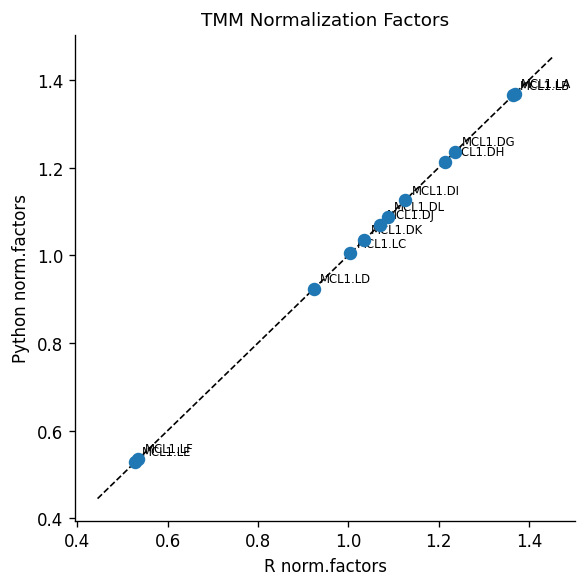

Max absolute difference: 2.04e-04


In [16]:
r_nf = r_norm['norm.factors'].values
p_nf = d_filt['samples']['norm.factors'].values

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(r_nf, p_nf, s=50, zorder=5)
mn, mx = min(r_nf.min(), p_nf.min()), max(r_nf.max(), p_nf.max())
margin = (mx - mn) * 0.1
ax.plot([mn - margin, mx + margin], [mn - margin, mx + margin], 'k--', lw=1)
ax.set_xlabel('R norm.factors'); ax.set_ylabel('Python norm.factors')
ax.set_title('TMM Normalization Factors')
for i, name in enumerate(counts_df.columns):
    ax.annotate(name, (r_nf[i], p_nf[i]), fontsize=7, xytext=(4, 4),
                textcoords='offset points')
plt.tight_layout()
plt.show()
print(f'Max absolute difference: {np.max(np.abs(r_nf - p_nf)):.2e}')

## 14. Tagwise Dispersions

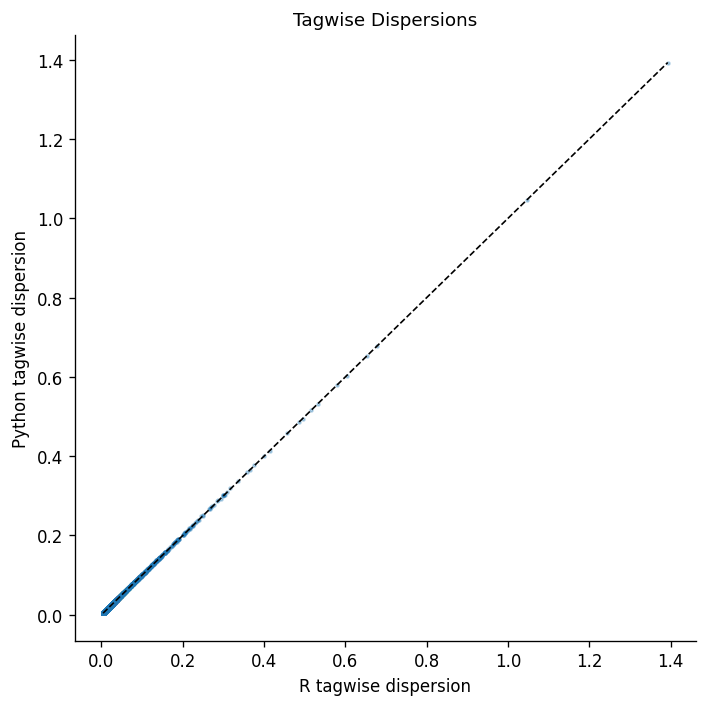

Common genes: 15804
Pearson correlation: 0.99996530


In [17]:
py_disp_df = pd.DataFrame({'tagwise.dispersion': d_filt['tagwise.dispersion']},
                          index=d_filt['genes']['GeneID'].values)
common_genes = r_disp_idx.index.intersection(py_disp_df.index)
r_tw = r_disp_idx.loc[common_genes, 'tagwise.dispersion'].values
p_tw = py_disp_df.loc[common_genes, 'tagwise.dispersion'].values

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(r_tw, p_tw, s=3, alpha=0.3, rasterized=True)
mn, mx = min(r_tw.min(), p_tw.min()), max(r_tw.max(), p_tw.max())
ax.plot([mn, mx], [mn, mx], 'k--', lw=1)
ax.set_xlabel('R tagwise dispersion'); ax.set_ylabel('Python tagwise dispersion')
ax.set_title('Tagwise Dispersions')
plt.tight_layout()
plt.show()
disp_corr = np.corrcoef(r_tw, p_tw)[0, 1]
print(f'Common genes: {len(common_genes)}')
print(f'Pearson correlation: {disp_corr:.8f}')

## 15. QL F-test P-values

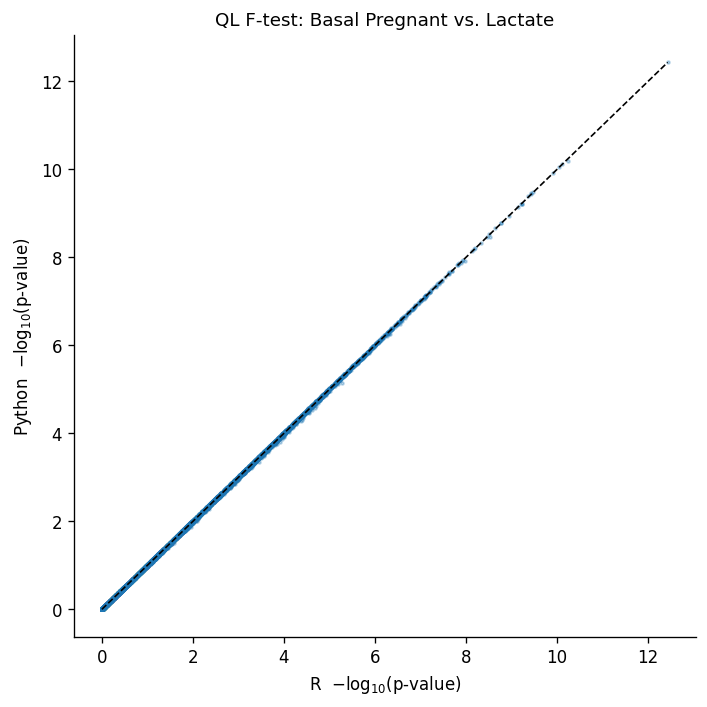

Genes: 15804, Pearson r: 0.99998719


In [18]:
def compare_pvalues(r_df, py_df, title):
    r_idx = r_df.set_index('GeneID')
    py_idx = py_df.set_index('GeneID')
    common = r_idx.index.astype(str).intersection(py_idx.index.astype(str))
    r_p = r_idx.loc[common, 'PValue'].values.astype(float)
    py_p = py_idx.loc[common, 'PValue'].values.astype(float)
    r_lp = -np.log10(np.maximum(r_p, 1e-300))
    py_lp = -np.log10(np.maximum(py_p, 1e-300))
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(r_lp, py_lp, s=3, alpha=0.3, rasterized=True)
    mx = max(r_lp.max(), py_lp.max())
    ax.plot([0, mx], [0, mx], 'k--', lw=1)
    ax.set_xlabel('R  $-$log$_{10}$(p-value)')
    ax.set_ylabel('Python  $-$log$_{10}$(p-value)')
    ax.set_title(title)
    plt.tight_layout(); plt.show()
    corr = np.corrcoef(r_lp, py_lp)[0, 1]
    print(f'Genes: {len(common)}, Pearson r: {corr:.8f}')
    return corr

corr_qlf_basal = compare_pvalues(r_qlf_basal, py_qlf_basal,
                                  'QL F-test: Basal Pregnant vs. Lactate')

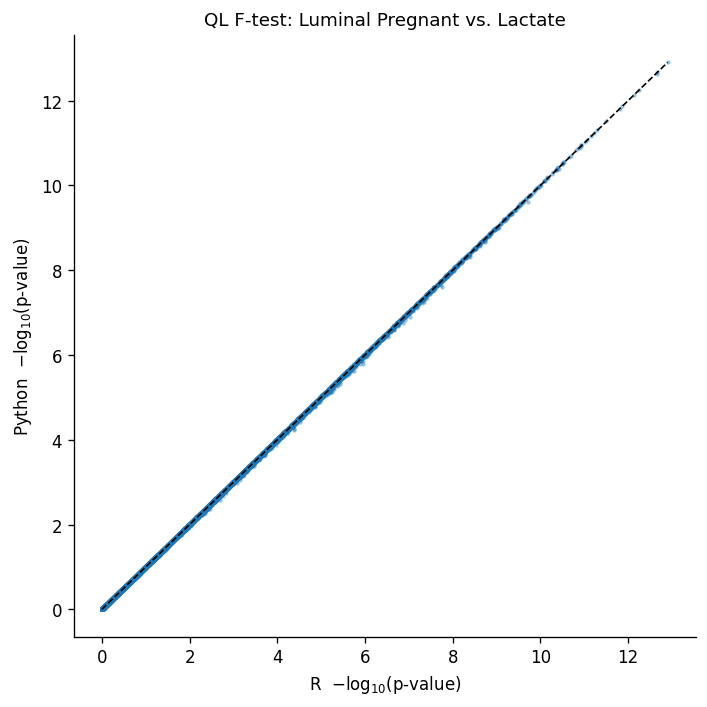

Genes: 15804, Pearson r: 0.99998875


In [19]:
corr_qlf_luminal = compare_pvalues(r_qlf_luminal, py_qlf_luminal,
                                    'QL F-test: Luminal Pregnant vs. Lactate')

## 16. TREAT P-values

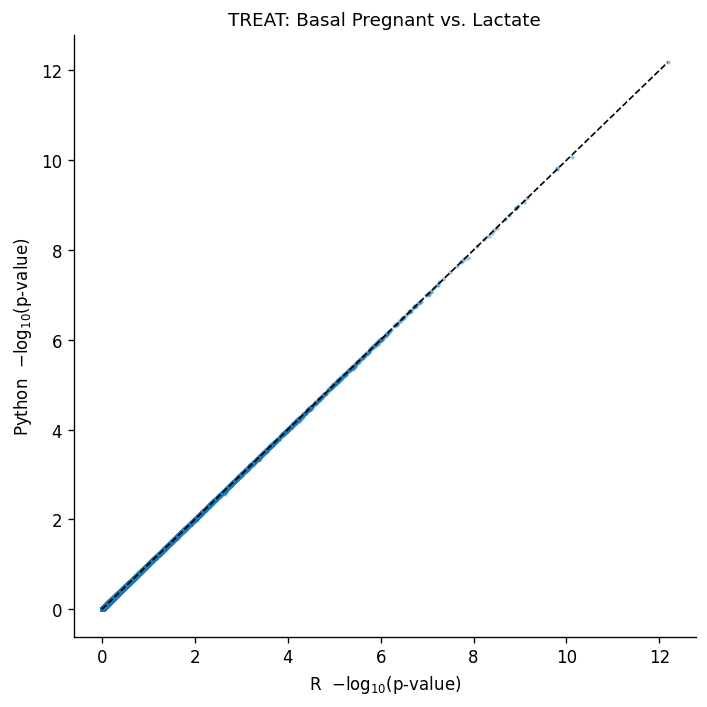

Genes: 15804, Pearson r: 0.99999663


In [20]:
corr_treat_basal = compare_pvalues(r_treat_basal, py_treat_basal,
                                    'TREAT: Basal Pregnant vs. Lactate')

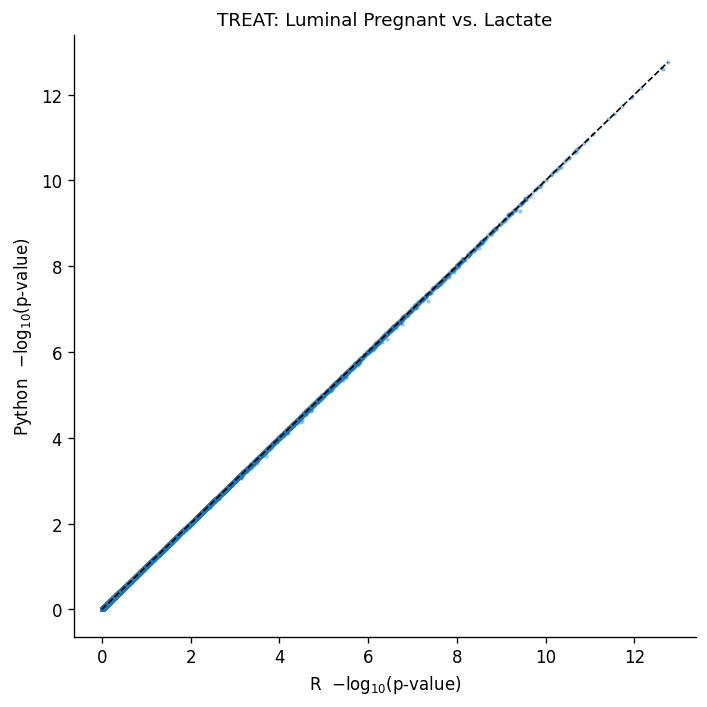

Genes: 15804, Pearson r: 0.99999453


In [21]:
corr_treat_luminal = compare_pvalues(r_treat_luminal, py_treat_luminal,
                                      'TREAT: Luminal Pregnant vs. Lactate')

## 17. LogFC Values

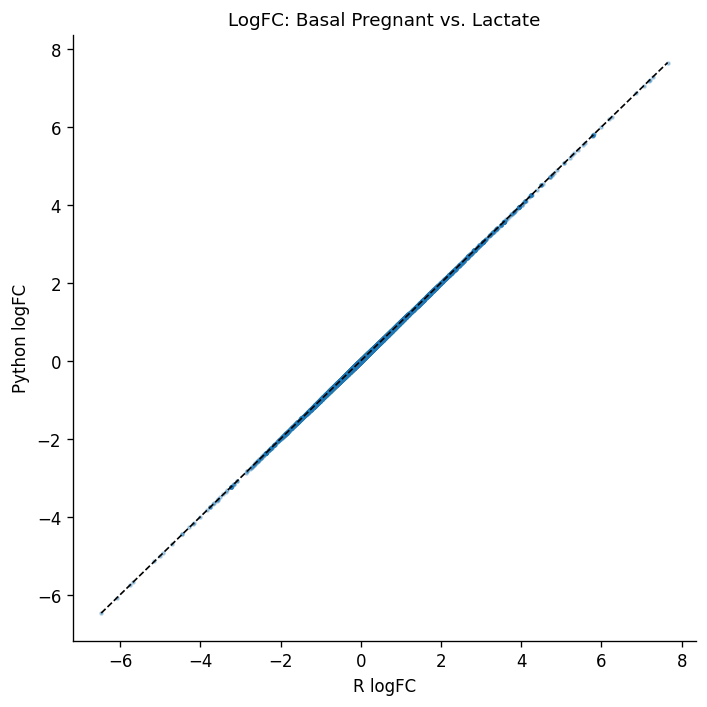

Pearson r: 1.00000000, Max |diff|: 6.05e-05


In [22]:
def compare_logfc(r_df, py_df, title):
    r_idx = r_df.set_index('GeneID')
    py_idx = py_df.set_index('GeneID')
    common = r_idx.index.astype(str).intersection(py_idx.index.astype(str))
    r_lfc = r_idx.loc[common, 'logFC'].values.astype(float)
    py_lfc = py_idx.loc[common, 'logFC'].values.astype(float)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(r_lfc, py_lfc, s=3, alpha=0.3, rasterized=True)
    mn, mx = min(r_lfc.min(), py_lfc.min()), max(r_lfc.max(), py_lfc.max())
    ax.plot([mn, mx], [mn, mx], 'k--', lw=1)
    ax.set_xlabel('R logFC'); ax.set_ylabel('Python logFC')
    ax.set_title(title)
    plt.tight_layout(); plt.show()
    corr = np.corrcoef(r_lfc, py_lfc)[0, 1]
    print(f'Pearson r: {corr:.8f}, Max |diff|: {np.max(np.abs(r_lfc - py_lfc)):.2e}')
    return corr

corr_lfc_basal = compare_logfc(r_qlf_basal, py_qlf_basal,
                                'LogFC: Basal Pregnant vs. Lactate')

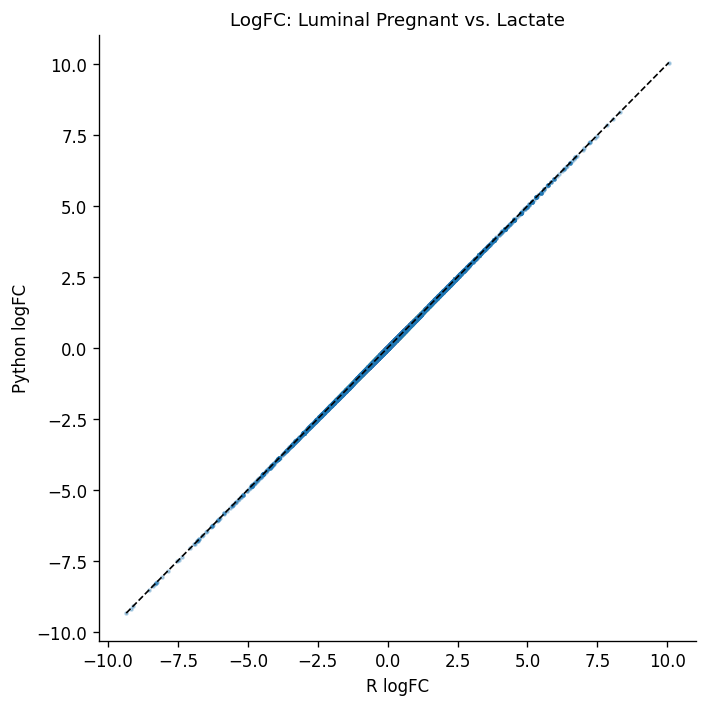

Pearson r: 1.00000000, Max |diff|: 4.12e-05


In [23]:
corr_lfc_luminal = compare_logfc(r_qlf_luminal, py_qlf_luminal,
                                  'LogFC: Luminal Pregnant vs. Lactate')

## 18. Summary

In [24]:
r_nf_max_diff = float(np.max(np.abs(r_nf - p_nf)))

summary = pd.DataFrame({
    'Comparison': [
        'Norm factors (max |diff|)',
        'Tagwise dispersion (r)',
        'QLF p-value basal (r)',
        'QLF p-value luminal (r)',
        'TREAT p-value basal (r)',
        'TREAT p-value luminal (r)',
        'LogFC basal (r)',
        'LogFC luminal (r)',
    ],
    'Value': [
        f'{r_nf_max_diff:.2e}',
        f'{disp_corr:.8f}',
        f'{corr_qlf_basal:.8f}',
        f'{corr_qlf_luminal:.8f}',
        f'{corr_treat_basal:.8f}',
        f'{corr_treat_luminal:.8f}',
        f'{corr_lfc_basal:.8f}',
        f'{corr_lfc_luminal:.8f}',
    ]
})
summary

,Comparison,Value
0,Norm factors (max |diff|),2.04e-04
1,Tagwise dispersion (r),0.99996530
2,QLF p-value basal (r),0.99998719
3,QLF p-value luminal (r),0.99998875
4,TREAT p-value basal (r),0.99999663
5,TREAT p-value luminal (r),0.99999453
6,LogFC basal (r),1.00000000
7,LogFC luminal (r),1.00000000


## 19. Four-Panel Summary Figure

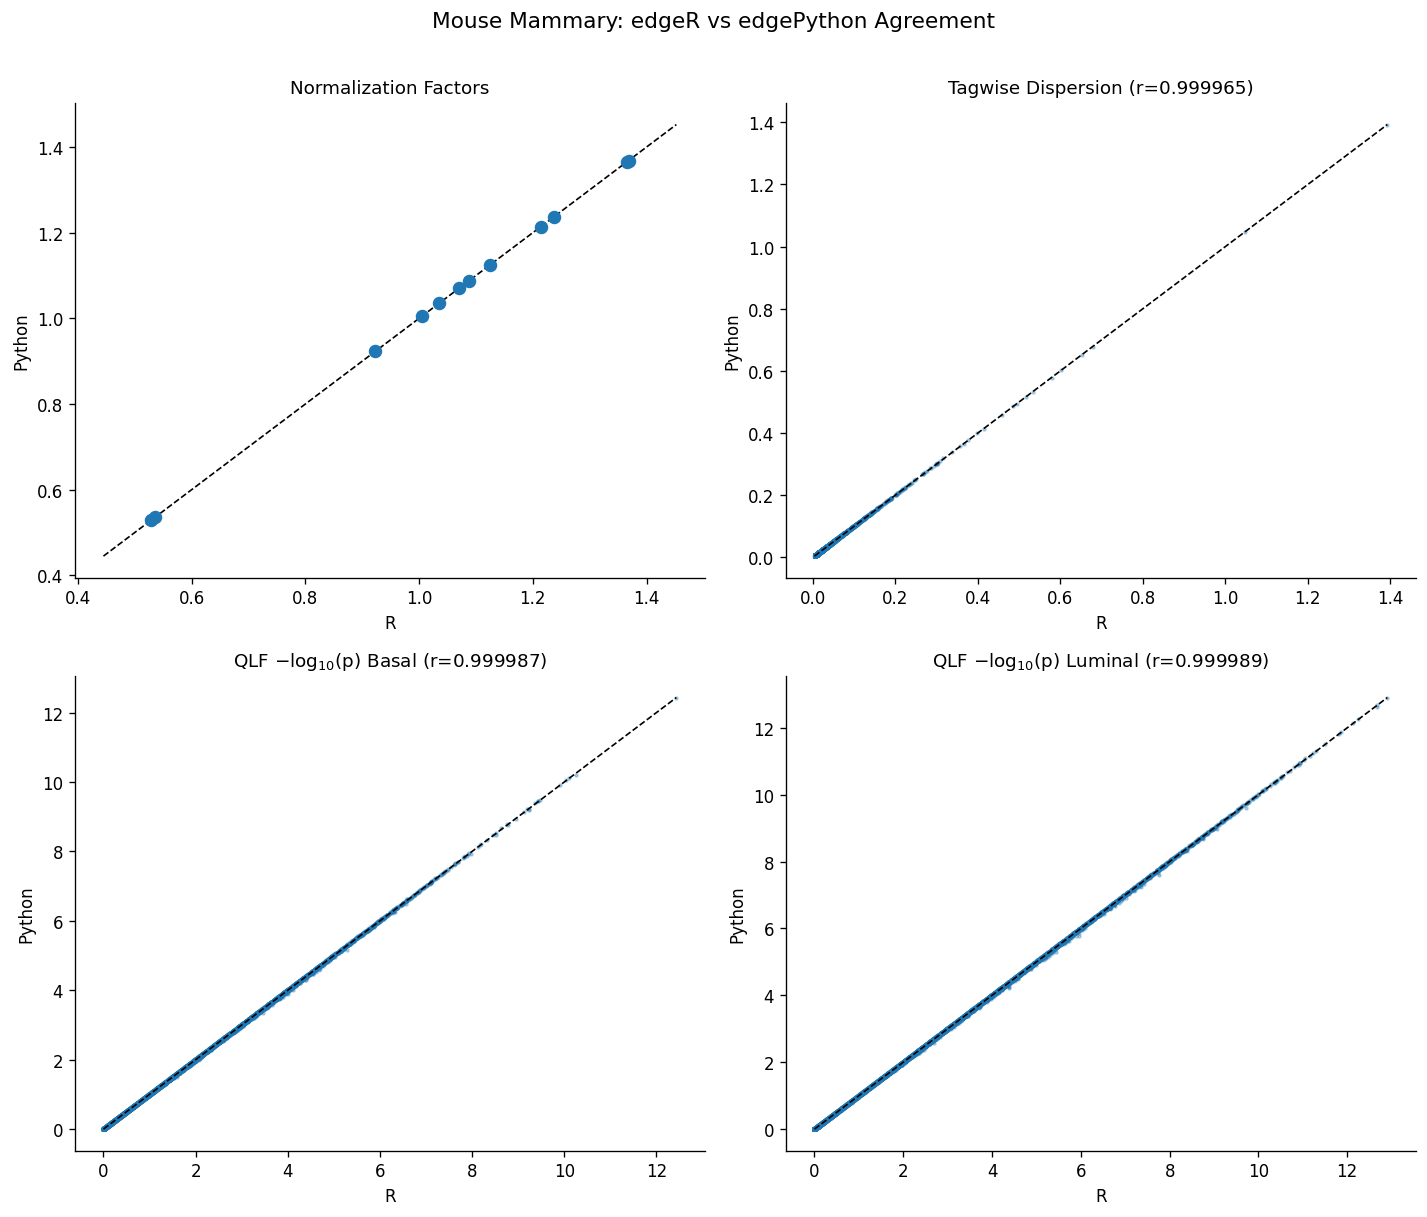

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

ax = axes[0, 0]
ax.scatter(r_nf, p_nf, s=50, zorder=5)
mn, mx = min(r_nf.min(), p_nf.min()), max(r_nf.max(), p_nf.max())
margin = (mx - mn) * 0.1
ax.plot([mn - margin, mx + margin], [mn - margin, mx + margin], 'k--', lw=1)
ax.set_xlabel('R'); ax.set_ylabel('Python'); ax.set_title('Normalization Factors')

ax = axes[0, 1]
ax.scatter(r_tw, p_tw, s=3, alpha=0.3, rasterized=True)
mn, mx = min(r_tw.min(), p_tw.min()), max(r_tw.max(), p_tw.max())
ax.plot([mn, mx], [mn, mx], 'k--', lw=1)
ax.set_xlabel('R'); ax.set_ylabel('Python')
ax.set_title(f'Tagwise Dispersion (r={disp_corr:.6f})')

ax = axes[1, 0]
r_b2 = r_qlf_basal.set_index('GeneID')
py_b2 = py_qlf_basal.set_index('GeneID')
cb = r_b2.index.astype(str).intersection(py_b2.index.astype(str))
r_lp = -np.log10(np.maximum(r_b2.loc[cb, 'PValue'].values.astype(float), 1e-300))
py_lp = -np.log10(np.maximum(py_b2.loc[cb, 'PValue'].values.astype(float), 1e-300))
ax.scatter(r_lp, py_lp, s=3, alpha=0.3, rasterized=True)
mx = max(r_lp.max(), py_lp.max())
ax.plot([0, mx], [0, mx], 'k--', lw=1)
ax.set_xlabel('R'); ax.set_ylabel('Python')
ax.set_title(f'QLF $-$log$_{{10}}$(p) Basal (r={corr_qlf_basal:.6f})')

ax = axes[1, 1]
r_l2 = r_qlf_luminal.set_index('GeneID')
py_l2 = py_qlf_luminal.set_index('GeneID')
cl = r_l2.index.astype(str).intersection(py_l2.index.astype(str))
r_lp2 = -np.log10(np.maximum(r_l2.loc[cl, 'PValue'].values.astype(float), 1e-300))
py_lp2 = -np.log10(np.maximum(py_l2.loc[cl, 'PValue'].values.astype(float), 1e-300))
ax.scatter(r_lp2, py_lp2, s=3, alpha=0.3, rasterized=True)
mx = max(r_lp2.max(), py_lp2.max())
ax.plot([0, mx], [0, mx], 'k--', lw=1)
ax.set_xlabel('R'); ax.set_ylabel('Python')
ax.set_title(f'QLF $-$log$_{{10}}$(p) Luminal (r={corr_qlf_luminal:.6f})')

fig.suptitle('Mouse Mammary: edgeR vs edgePython Agreement', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()